<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# **Mini Project 3:<br> Early detection of postnatal depression in women**

<pre>
Author: Thomas Stoll

Report filing date: March 2023 
</pre>

---

# 1. About the Data

**Data Source**

[PostPartum Depression dataset from Kaggle](https://www.kaggle.com/datasets/parvezalmuqtadir2348/postpartum-depression)


**Postpartum Depression Background Information**

Sourced from [Kaggle notebook](https://www.kaggle.com/code/yuvalaltman/postpartum-depression-analysis)

Postpartum depression, also called postnatal depression, is a type of mood disorder associated with childbirth. Medically referred as <i>major depression with postpartum onset</i>, it is defined as episodes of depression beginning within 4 weeks of giving birth - a time period corresponding to the rapid hormonal changes posited to contribute to vulnerability to depression. However, as psychosocial factors also play a major role in triggering postpartum depression, most researchers use a working definition of the postpartum period as lasting up to 6 months after delivery.<sup>[[1]](https://jamanetwork.com/journals/jama/article-abstract/194624)</sup>

The estimated prevalence of postpartum depression ranges from 6.5 to 12.9% or even higher in lower-income and middle-income countries.<sup>[[2]](https://www.nejm.org/doi/full/10.1056/nejmcp1607649)</sup>

Symptoms of postpartum depression often include sleep disturbance (beyond that associated with the care of the baby), anxiety, irritability, and a feeling of being overwhelmed, as well as an obsessional preoccupation with the baby’s health and feeding. Suicidal ideation and worries about causing harm to the baby have also been reported.<sup>[[3]](https://jamanetwork.com/journals/jamapsychiatry/article-abstract/1666651)</sup>

Early detection of symptoms and prompt initiation of treatment can greatly reduce adverse consequences. The use of screening tools, such as the Edinburgh Postnatal Depression Scale, is effective in increasing early diagnosis.<sup>[[1]](https://jamanetwork.com/journals/jama/article-abstract/194624)</sup>

**Data Background**

The authors of the dataset describe the data as originating from a questionnaire by a medical hospital. As this dataset does not contain a target variable `feeling depressed`, the authors explain that they used the variable **`feeling anxious`** as a reasonable predictor for postpartum depression.

**Data Dictionary**

|Variable|Key|
|:---|:---|
|Timestamp| mm/dd/yyyy hh:mm
|Age|25-30, 30-35, 35-40, 40-45, 45-50
|Feeling sad or tearful|yes, no, sometimes
|Irritable towards baby & partner|yes, no, sometimes
|Trouble sleeping at night|yes, no, two or more days a week
|Problems concentrating or making decision|yes, no, often
|Overeating or loss of appetite|yes, no, not at all
|Feeling anxious|yes, no
|Feeling of guilt|yes, no, maybe
|Problems of bonding with baby|yes, no, sometimes
|Suicide attempt|yes, no, not interested to say

---

# 2. Business question

* Can survey data be used to predict if women are at risk of developing postnatal depression? 

Why is this important? Early detection of symptoms and prompt initiation of treatment can greatly reduce adverse consequences. Deploying a machine learning model as a self-assessment tool (online-survey, app) could empower women in seeking help early.

---

# 3. Documentation summary and data insights

Exploratory data analysis, insights drawn from it and model prediction outcomes can be summarized as follows: 

|||
|:---|:---|
|**Initial data exploration:**|* The data set contains 11 features (including timestamp) and 1503 observations
||* Feature timestamp was dropped
||* Column names were cleaned
||* Target variable `feeling_anxious` is slightly imbalanced (yes: 65%; no: 35%)
||* All features (except timestamp) are categorical and their datatype is object
||* Missing values (27 in total) were imputed using mode after grouping by age bracket
|**Data visualization:**|**Countplots:**
||* The target variable `feeling_anxious` seems to correlate negatively with `feeling_of_guilt` and positively with `problems_of_bonding_with_baby`
||* All other features seem not to show a correlation 
||**Feature correlation (Theil's U):**
||* `feeling_of_guilt` shows the strongest correlation (~25%) to the target variable `feeling_anxious`, i.e. knowing the value of `feeling_of_guilt` provides ~25% of the information regarding the target variable
|**Model prediction:**|* A total of 7 prediction models were used, one neural network-based model (fully connected) and six tree-based models (Decision Tree, Random Forest, AdaBoost, LightGBM, XGBoost, CatBoost)
||* Categorical variables were encoded as follows: Binary target variable `feeling_anxious` was encoded using label encoding, ordinal feature `age` was encoded using ordinal encoding and nominal features (all other variables) were encoded using dummy encoding
||* Encoding resulted in a total of 25 feature columns
||* Data was split into 80% train (1202 observations) and 20% test (301 observations)
||* Hyperparameter tuning was performed on all tree-based models. Tuning of LightGBM, XGBoost and CatBoost had only miniscule effect on model performance
||* The neural network model architecture was optimized by trial and error (e.g. by adjusting number of hidden layers and number of nodes) using learning curves of loss and accuracy as an assessment tool
||* CatBoost and XGBoost were the best performers (FN: 0, FP:0), closely followed by LightGBM (FN: 2, FP:0)
||* The neural network-based model performed slightly worse than LightGBM
||* Decision Tree and Random Forest were midfield
||* AdaBoost was the worst performer
||* Feature importance: Each tree-based model showed a slightly different order of feature importance, although in all models the feature `feeling_of_guilt` was the most important feature

**Model Performance Summary Table**

|Model|Mean CV Score$^{1}$|Accuracy|Precision|Recall|F1-Score|ROC_AUC
|:---|:---|:---|:---|:---|:---|:---|
|CatBoost|0.979|1.0|1.0|1.0|1.0|1.0 
|XGBoost|0.974|1.0|1.0|1.0|1.0|1.0 
|LightGBM|0.976|0.993|1.0|0.990|0.995|0.995
|Neural Network|n.d.$^{2}$|0.973|0.985|0.974|0.979|0.973
|Random Forest|0.900|0.870|0.894|0.908|0.901|0.854
|Decision Tree|0.878|0.877|0.904|0.908|0.906|0.864
|AdaBoost|0.849|0.844|0.853|0.918|0.885|0.812


$^{1}$Mean of 3-times 10-fold cross-validation scores 

$^{2}$not determined

---

# 4. Loading Python libraries

In [ ]:
# !pip install catboost

In [256]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.ticker import StrMethodFormatter
from colorama import Fore, Style
from dython.nominal import associations

import lightgbm
import xgboost
import catboost
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV

from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import clear_session
from tensorflow.config import list_physical_devices
from tensorflow.random import set_seed
set_seed(42)

%matplotlib inline

In [257]:
print("Num GPUs Available: ", len(list_physical_devices('GPU')))

Num GPUs Available:  0


In [258]:
# Check library version 
print('Numpy: ', np.__version__)
print('Pandas: ', pd.__version__)
print('Seaborn: ', sns.__version__)

Numpy:  1.24.2
Pandas:  1.5.1
Seaborn:  0.12.2


---

# 5. Exploratory data analysis

## 5.1. Loading data

In [4]:
# Load dataset
df = pd.read_csv('post natal data.csv')

## 5.2. Exploring and cleaning data

In [5]:
# Check data dimension
df.shape

(1503, 11)

In [ ]:
# Preview data
df.head(5)

Timestamp    Age Feeling sad or Tearful  \
0  6/14/2022 20:02  35-40                    Yes   
1  6/14/2022 20:03  40-45                    Yes   
2  6/14/2022 20:04  35-40                    Yes   
3  6/14/2022 20:05  35-40                    Yes   
4  6/14/2022 20:06  40-45                    Yes   

  Irritable towards baby & partner Trouble sleeping at night  \
0                              Yes   Two or more days a week   
1                               No                        No   
2                               No                       Yes   
3                              Yes                       Yes   
4                               No   Two or more days a week   

  Problems concentrating or making decision Overeating or loss of appetite  \
0                                       Yes                            Yes   
1                                       Yes                            Yes   
2                                       Yes                            Yes   
3                                       Yes                             No   
4                                       Yes                             No   

  Feeling anxious Feeling of guilt Problems of bonding with baby  \
0             Yes               No                           Yes   
1              No              Yes                           Yes   
2             Yes               No                     Sometimes   
3             Yes            Maybe                            No   
4             Yes               No                           Yes   

  Suicide attempt  
0             Yes  
1              No  
2              No  
3              No  
4              No

In [ ]:
 df.tail(5)

Timestamp    Age Feeling sad or Tearful  \
1498  6/15/2022 0:35  30-35                    Yes   
1499  6/15/2022 0:35  25-30              Sometimes   
1500  6/15/2022 0:35  25-30                     No   
1501  6/15/2022 0:36  25-30                     No   
1502  6/15/2022 0:36  45-50              Sometimes   

     Irritable towards baby & partner Trouble sleeping at night  \
1498                               No   Two or more days a week   
1499                               No                        No   
1500                        Sometimes   Two or more days a week   
1501                        Sometimes                       Yes   
1502                        Sometimes   Two or more days a week   

     Problems concentrating or making decision Overeating or loss of appetite  \
1498                                        No                             No   
1499                                     Often                             No   
1500                                        No                             No   
1501                                     Often                             No   
1502                                        No                             No   

     Feeling anxious Feeling of guilt Problems of bonding with baby  \
1498             Yes            Maybe                     Sometimes   
1499             Yes            Maybe                           Yes   
1500              No              Yes                            No   
1501             Yes               No                            No   
1502              No            Maybe                            No   

            Suicide attempt  
1498                     No  
1499                     No  
1500  Not interested to say  
1501                     No  
1502                     No

In [6]:
# Drop 'Timestamp'
df.drop('Timestamp', axis=1, inplace=True)

In [7]:
# Clean column names
df.columns = df.columns.str.lower().str.replace(" ", "_").str.replace("&", "and")

In [ ]:
df.head()

age feeling_sad_or_tearful irritable_towards_baby_and_partner  \
0  35-40                    Yes                                Yes   
1  40-45                    Yes                                 No   
2  35-40                    Yes                                 No   
3  35-40                    Yes                                Yes   
4  40-45                    Yes                                 No   

  trouble_sleeping_at_night problems_concentrating_or_making_decision  \
0   Two or more days a week                                       Yes   
1                        No                                       Yes   
2                       Yes                                       Yes   
3                       Yes                                       Yes   
4   Two or more days a week                                       Yes   

  overeating_or_loss_of_appetite feeling_anxious feeling_of_guilt  \
0                            Yes             Yes               No   
1                            Yes              No              Yes   
2                            Yes             Yes               No   
3                             No             Yes            Maybe   
4                             No             Yes               No   

  problems_of_bonding_with_baby suicide_attempt  
0                           Yes             Yes  
1                           Yes              No  
2                     Sometimes              No  
3                            No              No  
4                           Yes              No

In [ ]:
# Summarize data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503 entries, 0 to 1502
Data columns (total 10 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   age                                        1503 non-null   object
 1   feeling_sad_or_tearful                     1503 non-null   object
 2   irritable_towards_baby_and_partner         1497 non-null   object
 3   trouble_sleeping_at_night                  1503 non-null   object
 4   problems_concentrating_or_making_decision  1491 non-null   object
 5   overeating_or_loss_of_appetite             1503 non-null   object
 6   feeling_anxious                            1503 non-null   object
 7   feeling_of_guilt                           1494 non-null   object
 8   problems_of_bonding_with_baby              1503 non-null   object
 9   suicide_attempt                            1503 non-null   object
dtypes: object(10)
memory usage: 117.5+ K

In [ ]:
# Generate descriptive statistics
df.describe(include='all').T

count unique  \
age                                        1503      5   
feeling_sad_or_tearful                     1503      3   
irritable_towards_baby_and_partner         1497      3   
trouble_sleeping_at_night                  1503      3   
problems_concentrating_or_making_decision  1491      3   
overeating_or_loss_of_appetite             1503      3   
feeling_anxious                            1503      2   
feeling_of_guilt                           1494      3   
problems_of_bonding_with_baby              1503      3   
suicide_attempt                            1503      3   

                                                               top freq  
age                                                          40-45  364  
feeling_sad_or_tearful                                         Yes  536  
irritable_towards_baby_and_partner                             Yes  555  
trouble_sleeping_at_night                  Two or more days a week  640  
problems_concentrating_or_making_decision                       No  583  
overeating_or_loss_of_appetite                                  No  841  
feeling_anxious                                                Yes  980  
feeling_of_guilt                                                No  624  
problems_of_bonding_with_baby                                   No  557  
suicide_attempt                                                 No  709

In [ ]:
# Get *absolute* counts of unique values for features based on dtypes
col_name = df.select_dtypes(include='object').columns

for index, col in enumerate(col_name):
    print(f'\033[1;3m{col_name[index]}:\033[0m\n{df[col].value_counts()}\n')

age:
40-45    364
35-40    349
30-35    338
45-50    271
25-30    181
Name: age, dtype: int64

feeling_sad_or_tearful:
Yes          536
No           524
Sometimes    443
Name: feeling_sad_or_tearful, dtype: int64

irritable_towards_baby_and_partner:
Yes          555
No           499
Sometimes    443
Name: irritable_towards_baby_and_partner, dtype: int64

trouble_sleeping_at_night:
Two or more days a week    640
Yes                        445
No                         418
Name: trouble_sleeping_at_night, dtype: int64

problems_concentrating_or_making_decision:
No       583
Often    473
Yes      435
Name: problems_concentrating_or_making_decision, dtype: int64

overeating_or_loss_of_appetite:
No            841
Yes           343
Not at all    319
Name: overeating_or_loss_of_appetite, dtype: int64

feeling_anxious:
Yes    980
No     523
Name: feeling_anxious, dtype: int64

feeling_of_guilt:
No       624
Maybe    528
Yes      342
Name: feeling_of_guilt, dtype: int64

problems_of_bonding_wi

In [ ]:
# Get *relative* counts of unique values for features based on dtypes
col_name = df.select_dtypes(include='object').columns

for index, col in enumerate(col_name):
    print(f'\033[1;3m{col_name[index]} (%):\033[0m\n{np.round(df[col].value_counts(normalize=True)*100, 1)}\n')

age (%):
40-45    24.2
35-40    23.2
30-35    22.5
45-50    18.0
25-30    12.0
Name: age, dtype: float64

feeling_sad_or_tearful (%):
Yes          35.7
No           34.9
Sometimes    29.5
Name: feeling_sad_or_tearful, dtype: float64

irritable_towards_baby_and_partner (%):
Yes          37.1
No           33.3
Sometimes    29.6
Name: irritable_towards_baby_and_partner, dtype: float64

trouble_sleeping_at_night (%):
Two or more days a week    42.6
Yes                        29.6
No                         27.8
Name: trouble_sleeping_at_night, dtype: float64

problems_concentrating_or_making_decision (%):
No       39.1
Often    31.7
Yes      29.2
Name: problems_concentrating_or_making_decision, dtype: float64

overeating_or_loss_of_appetite (%):
No            56.0
Yes           22.8
Not at all    21.2
Name: overeating_or_loss_of_appetite, dtype: float64

feeling_anxious (%):
Yes    65.2
No     34.8
Name: feeling_anxious, dtype: float64

feeling_of_guilt (%):
No       41.8
Maybe    35.3
Yes

**Documentation**
* Target variable `feeling_anxious` is slightly imbalanced, but since decision tree-based models are used this will not be an issue

In [ ]:
# Check for missing values
df.isna().sum()

age                                           0
feeling_sad_or_tearful                        0
irritable_towards_baby_and_partner            6
trouble_sleeping_at_night                     0
problems_concentrating_or_making_decision    12
overeating_or_loss_of_appetite                0
feeling_anxious                               0
feeling_of_guilt                              9
problems_of_bonding_with_baby                 0
suicide_attempt                               0
dtype: int64

**Documentation**
* Data will be imputed before modelling using 'mode'

In [ ]:
# Alternatively, drop rows with missing values
# df.dropna(inplace=True) 
# df.isna().sum()

---

## 5.3. Visualizing data

### 5.3.1. Count plots

**Plotting the counts of observations in each categorical bin using bars**

In [ ]:
# Get list of available styles
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [ ]:
plt.style.use('seaborn-dark-palette')

In [ ]:
val_yes, val_no = df['feeling_anxious'].value_counts(normalize=True)*100
val_yes, val_no

(65.20292747837658, 34.79707252162342)

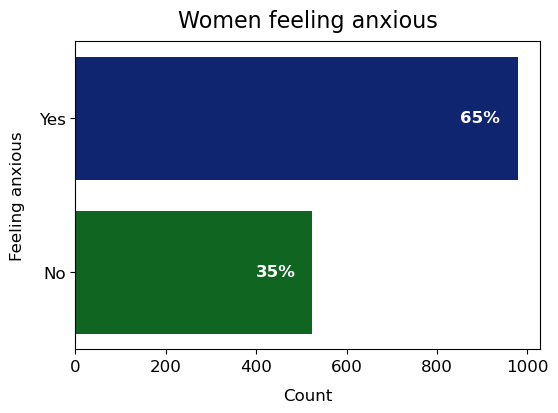

In [ ]:
# Count plot of target variable 'feeling_anxious'

plt.figure(figsize=(6,4))
sns.countplot(y='feeling_anxious', data=df)
plt.xlabel(xlabel='Count', fontsize=12, labelpad=10)
plt.ylabel(ylabel='Feeling anxious', fontsize=12, labelpad=10)
plt.text(x=850, y=0, s=str(int(np.round(val_yes))) + "%", fontsize=12, fontweight='bold', color='w', va='center')
plt.text(x=400, y=1, s=str(int(np.round(val_no))) + "%", fontsize=12, fontweight='bold', color='w', va='center')
plt.title(label='Women feeling anxious', fontsize=16, pad=10)
plt.tick_params(axis='both', labelsize=12);

**Documentation**

Target variable is slightly imbalanced

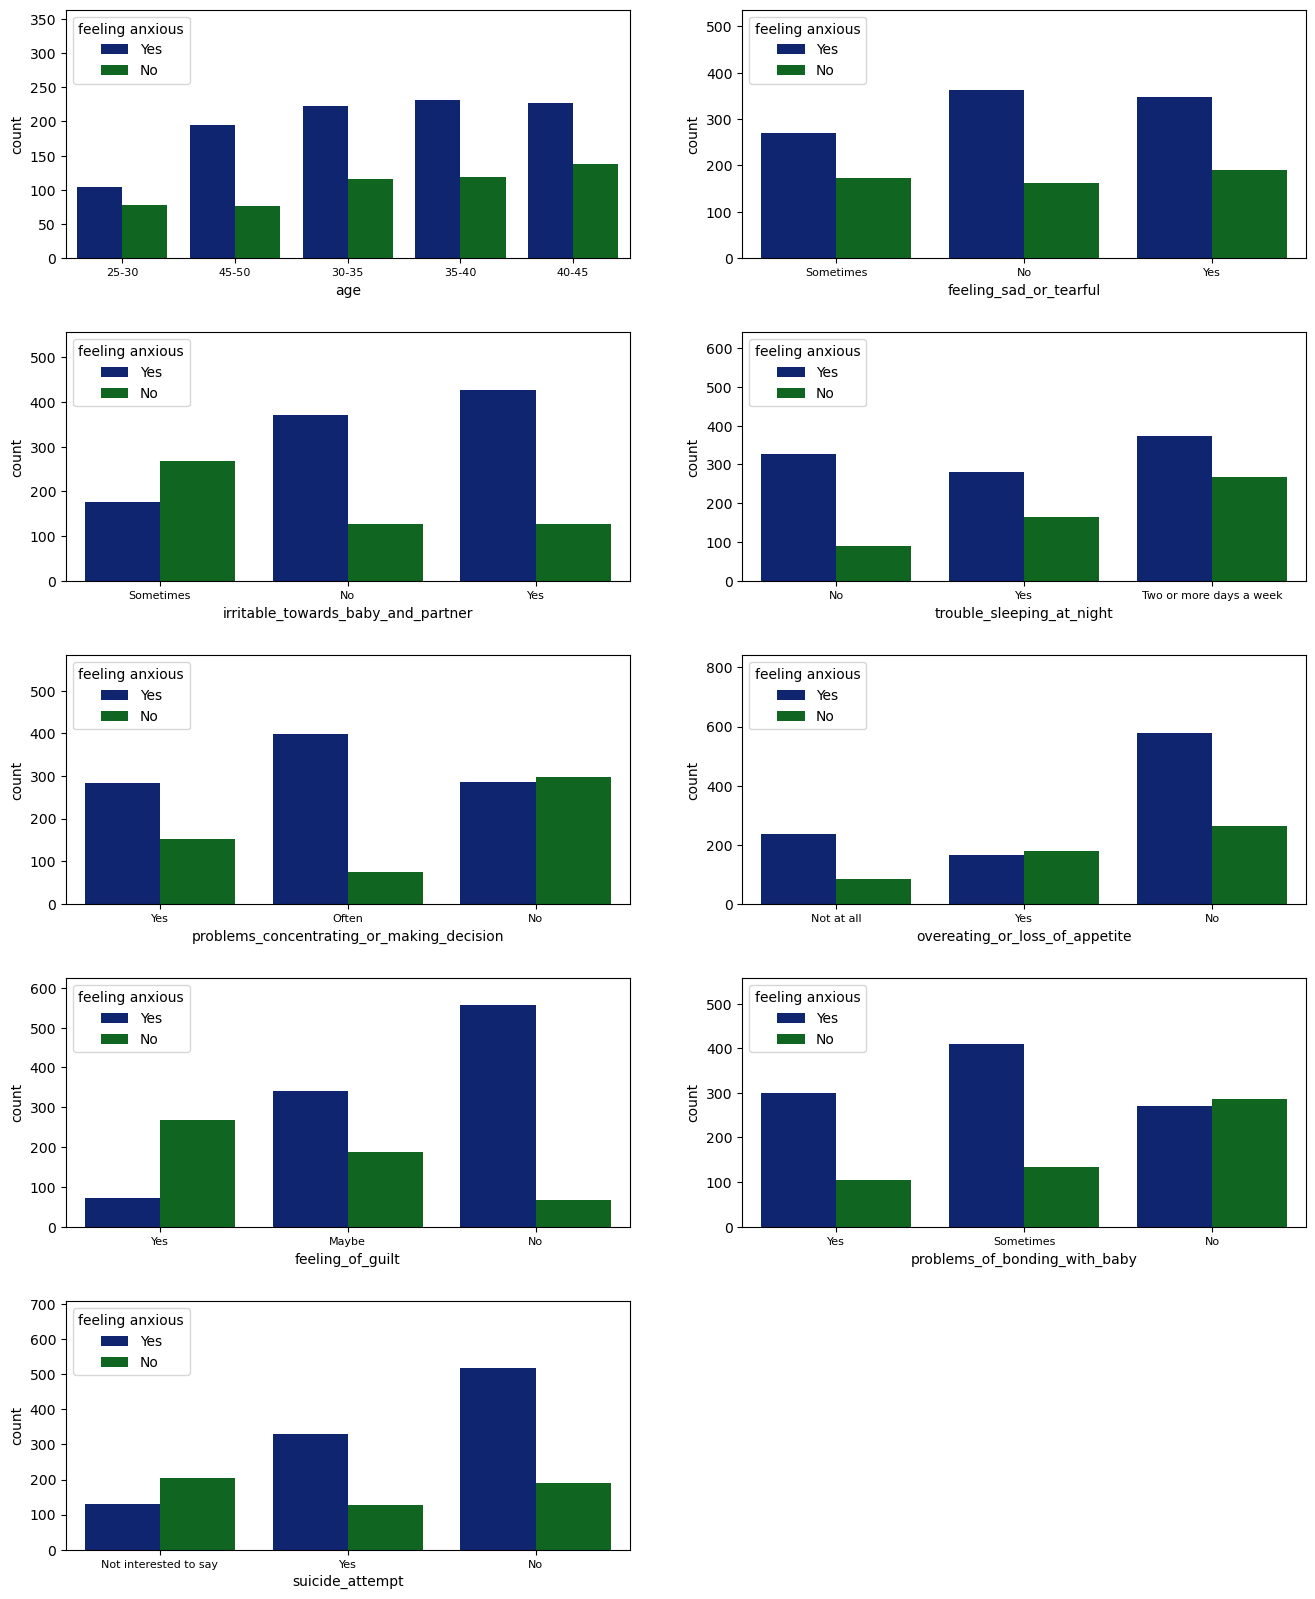

In [ ]:
# Count plots of feature variables 

# Features to plot
columns = [c for c in df.columns if c != 'feeling_anxious']
    
# Creating subplot axes
fig, axes = plt.subplots(5, 2, figsize=(16,20), sharey=False)
axes[4,1].set_axis_off()

# Iterating through axes and columns
for name, ax in zip(columns, axes.flatten()):
    sns.countplot(x=name, hue='feeling_anxious', data=df, order=df[name].value_counts(ascending=True).index, ax=ax)
    ax.tick_params(axis='x', labelsize=8)
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    ax.set_ylim([0, max(df[name].value_counts())])
    ax.legend(title='feeling anxious', loc='upper left')
    plt.subplots_adjust(hspace=0.3);

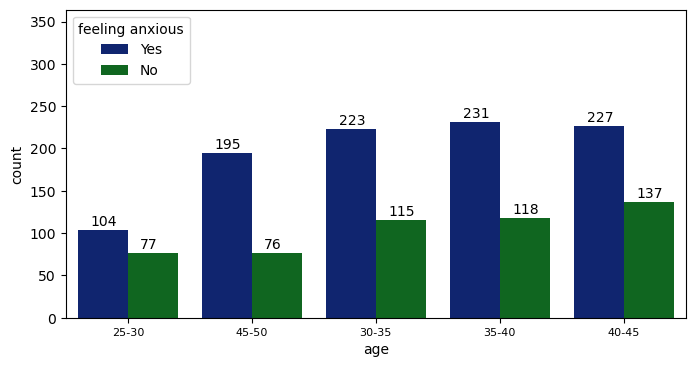

In [ ]:
# Count plot of feature variable 'age' with annotation

# Feature to plot
name = 'age'
    
# Creating subplot axes
fig, ax = plt.subplots(1, 1, figsize=(8,4), sharey=False)
# axes[2,1].set_axis_off()

sns.countplot(x=name, hue='feeling_anxious', data=df, order=df[name].value_counts(ascending=True).index, ax=ax)
ax.tick_params(axis='x', labelsize=8)
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.subplots_adjust(hspace=0.3)
ax.set_ylim([0, max(df[name].value_counts())])
ax.legend(title='feeling anxious', loc='upper left')

for p in ax.patches:
    txt = str(int(np.round(p.get_height())))
    x = p.get_x()+0.1
    y = p.get_height()+5
    ax.text(x, y, txt);   

**Documentation**

From the count plot one could deduce the correlation with 'feeling anxious' is:
* negative with 'feeling of guilt'
* positive with 'problems of bonding with baby'

All other features seem not to show a correlation 

### 5.3.2. Feature correlation: Theil's U (Uncertainty Coefficient)

Theil's U, also known as the Uncertainty Coefficient, calculates statistic for categorical-categorical association. Formaly marked as U(x|y), this coefficient provides a value in the range of [0,1], where 0 means y provides no information about x, and 1 means y provides full information about x.

How to read the Theil's U heatmap:
* Knowing the value of feature on the y-axis
* Provides information regarding feature on the x-axis

In [ ]:
# Moving target variable to last position in df
df_corr = df.copy()
df_corr['feeling_anxious'] = df_corr.pop('feeling_anxious')
df_corr.head()

age feeling_sad_or_tearful irritable_towards_baby_and_partner  \
0  35-40                    Yes                                Yes   
1  40-45                    Yes                                 No   
2  35-40                    Yes                                 No   
3  35-40                    Yes                                Yes   
4  40-45                    Yes                                 No   

  trouble_sleeping_at_night problems_concentrating_or_making_decision  \
0   Two or more days a week                                       Yes   
1                        No                                       Yes   
2                       Yes                                       Yes   
3                       Yes                                       Yes   
4   Two or more days a week                                       Yes   

  overeating_or_loss_of_appetite feeling_of_guilt  \
0                            Yes               No   
1                            Yes              Yes   
2                            Yes               No   
3                             No            Maybe   
4                             No               No   

  problems_of_bonding_with_baby suicide_attempt feeling_anxious  
0                           Yes             Yes             Yes  
1                           Yes              No              No  
2                     Sometimes              No             Yes  
3                            No              No             Yes  
4                           Yes              No             Yes

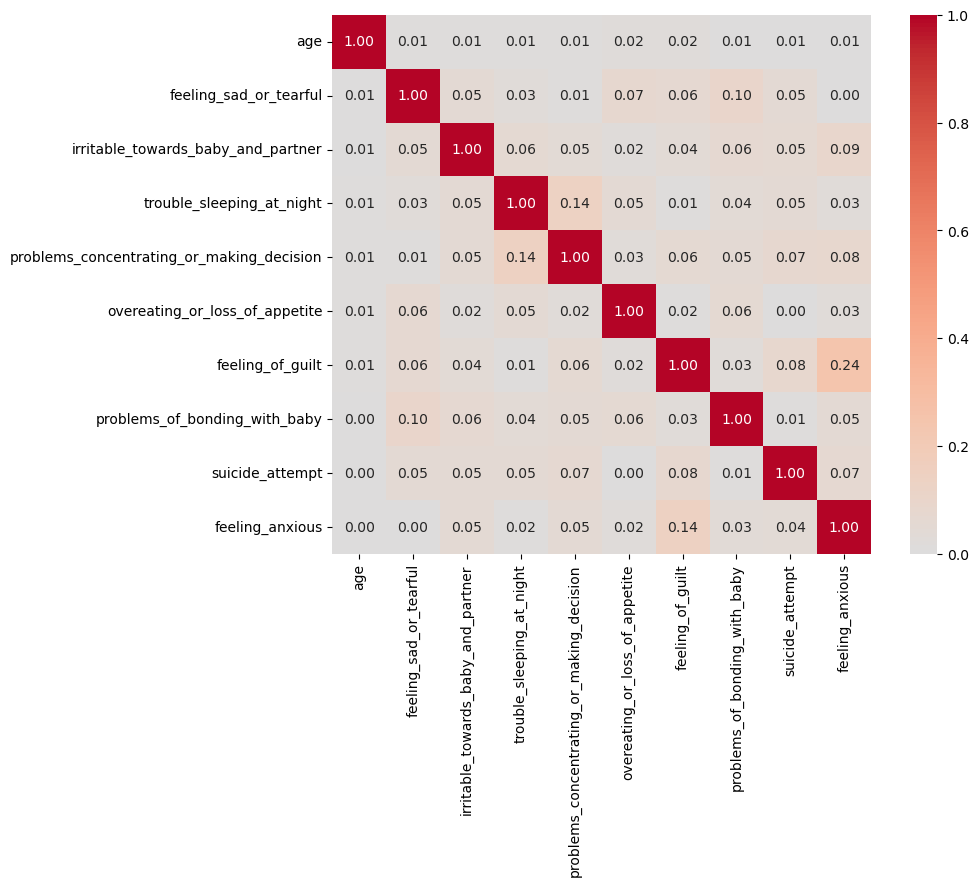

In [ ]:
# Generating Theil’s U pairwise association plot
fig, ax = plt.subplots(figsize = (10, 7))

# Estimate and generate Theil's U association plot
theils_u = associations(df_corr, nom_nom_assoc='theil', vmin=0, vmax=1, cmap="coolwarm", fmt='.2f', ax=ax)

In [ ]:
theils_u["corr"]

age  feeling_sad_or_tearful  \
age                                        1.000000                0.008947   
feeling_sad_or_tearful                     0.006194                1.000000   
irritable_towards_baby_and_partner         0.007465                0.048644   
trouble_sleeping_at_night                  0.008667                0.030428   
problems_concentrating_or_making_decision  0.010085                0.010252   
overeating_or_loss_of_appetite             0.012170                0.064382   
feeling_of_guilt                           0.011192                0.064915   
problems_of_bonding_with_baby              0.004966                0.098857   
suicide_attempt                            0.004975                0.047164   
feeling_anxious                            0.002482                0.002257   

                                           irritable_towards_baby_and_partner  \
age                                                                  0.010580   
feeling_sad_or_tearful                                               0.047732   
irritable_towards_baby_and_partner                                   1.000000   
trouble_sleeping_at_night                                            0.053918   
problems_concentrating_or_making_decision                            0.047381   
overeating_or_loss_of_appetite                                       0.018215   
feeling_of_guilt                                                     0.042472   
problems_of_bonding_with_baby                                        0.062792   
suicide_attempt                                                      0.051746   
feeling_anxious                                                      0.053486   

                                           trouble_sleeping_at_night  \
age                                                         0.012697   
feeling_sad_or_tearful                                      0.030860   
irritable_towards_baby_and_partner                          0.055729   
trouble_sleeping_at_night                                   1.000000   
problems_concentrating_or_making_decision                   0.144037   
overeating_or_loss_of_appetite                              0.047548   
feeling_of_guilt                                            0.014857   
problems_of_bonding_with_baby                               0.041735   
suicide_attempt                                             0.051883   
feeling_anxious                                             0.015357   

                                           problems_concentrating_or_making_decision  \
age                                                                         0.014135   
feeling_sad_or_tearful                                                      0.009948   
irritable_towards_baby_and_partner                                          0.046855   
trouble_sleeping_at_night                                                   0.137812   
problems_concentrating_or_making_decision                                   1.000000   
overeating_or_loss_of_appetite                                              0.024496   
feeling_of_guilt                                                            0.055423   
problems_of_bonding_with_baby                                               0.049094   
suicide_attempt                                                             0.069266   
feeling_anxious                                                             0.047892   

                                           overeating_or_loss_of_appetite  \
age                                                              0.019425   
feeling_sad_or_tearful                                           0.071144   
irritable_towards_baby_and_partner                               0.020512   
trouble_sleeping_at_night                                        0.051807   
problems_concentrating_or_making_decision                        0.027896   
overeating_or_loss_of_appetite                                

**Documentation**

* 'Feeling of guilt' shows the strongest correlation (~25%) to the target variable `feeling_anxious`, i.e. knowing the value of 'feeling of guilt' provides ~25% of the information regarding the target variable

---

# 6. Modelling

## 6.1. Functions 

### 6.1.1. Summary report

In [8]:
def summary_report_tree(model, X_test, y_test):
    """
    * Summary Report for Tree-based Models *
    
    Function to generate predictions and probabilities on input data, 
    output model performance indicators and 
    plot confusion matrix, precision-recall and ROC curve
    """
    # Make prediction on input data
    y_pred = model.predict(X_test)
    
    # Generate prediction probabilities for input data
    y_test_prob = model.predict_proba(X_test)[:,1]
                       
    # Model performance    
    accuracy_ = accuracy_score(y_test, y_pred)
    precision_ = precision_score(y_test, y_pred)
    recall_ = recall_score(y_test, y_pred)
    f1_ = f1_score(y_test, y_pred)
    roc_auc_ = roc_auc_score(y_test, y_pred)

    print(f'\033[1mSummary Report\033[0m')
    print(f'\033[1mAccuracy:  {accuracy_:.2f}\033[0m [TP / N] Proportion of predicted labels that match true labels')
    print(f'\033[1mPrecision: {precision_:.2f}\033[0m [TP / (TP + FP)] Ability of the classifier not to label as positive a sample that is negative')
    print(f'\033[1mRecall:    {recall_:.2f}\033[0m [TP / (TP + FN)] Ability of the classifier to find all positive samples')
    print(f'\033[1mF1-score:  {f1_:.2f}\033[0m [F1 = 2 * (precision * recall) / (precision + recall)] Harmonic mean of the precision and recall')
    print(f'\033[1mROC AUC:   {roc_auc_:.2f}\033[0m')
    print(113*'-')
    print('TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples')
    print(113*'-', '\n')
    
    # Confusion Matrix
    mat = confusion_matrix(y_test, y_pred)
    
    # Precision/Recall
    precision, recall, _ = precision_recall_curve(y_test, y_test_prob)

    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test, y_test_prob)
    roc_auc = auc(fpr, tpr)

    # Plot
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    fig.subplots_adjust(left=0.02, right=0.98, wspace=0.2)

    # Confusion Matrix
    group_names = ['TN','FP','FN','TP']
    group_counts = ["{0:0.0f}".format(value) for value in mat.flatten()]
    labels = [f"{v1}\n\n{v2}" for v1, v2 in zip(group_names,group_counts)]
    labels = np.asarray(labels).reshape(2,2)
    
    sns.heatmap(mat, annot=labels, cmap=plt.cm.Blues, fmt="", ax=ax[0])
    ax[0].set_title('Confusion Matrix')
    ax[0].set_xlabel('Predicted label')
    ax[0].set_ylabel('True label')

    # Precision/Recall
    step_kwargs = {'step': 'post'}
    ax[1].step(recall, precision, color='b', alpha=0.2, where='post')
    ax[1].fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    ax[1].set_ylim([0.0, 1.0])
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('2-class Precision-Recall curve')

    # ROC
    ax[2].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    ax[2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[2].set_xlim([0.0, 1.0])
    ax[2].set_ylim([0.0, 1.0])
    ax[2].set_xlabel('False Positive Rate (1-specificity)')
    ax[2].set_ylabel('True Positive Rate (sensitivity)')
    ax[2].set_title('Receiver Operating Characteristic')
    ax[2].legend(loc='lower right')
    
    plt.show()
    
    return accuracy_, precision_, recall_, f1_, roc_auc_

In [9]:
def summary_report_nn(model, X_test, y_test):
    """
    * Summary Report for Neural Network-based Models *
    
    Function to generate predictions and probabilities on input data, 
    output model performance indicators and 
    plot confusion matrix, precision-recall and ROC curve
    """
    # Make prediction on input data
    y_pred = ((model.predict(X_test)>0.5)*1).flatten()
    
    # Generate prediction probabilities for input data
    y_test_prob = model.predict(X_test)
                       
    # Model performance    
    accuracy_ = accuracy_score(y_test, y_pred)
    precision_ = precision_score(y_test, y_pred)
    recall_ = recall_score(y_test, y_pred)
    f1_ = f1_score(y_test, y_pred)
    roc_auc_ = roc_auc_score(y_test, y_pred)

    print(f'\n\033[1mSummary Report\033[0m')
    print(f'\033[1mAccuracy:  {accuracy_:.2f}\033[0m [TP / N] Proportion of predicted labels that match true labels')
    print(f'\033[1mPrecision: {precision_:.2f}\033[0m [TP / (TP + FP)] Ability of the classifier not to label as positive a sample that is negative')
    print(f'\033[1mRecall:    {recall_:.2f}\033[0m [TP / (TP + FN)] Ability of the classifier to find all positive samples')
    print(f'\033[1mF1-score:  {f1_:.2f}\033[0m [F1 = 2 * (precision * recall) / (precision + recall)] Harmonic mean of the precision and recall')
    print(f'\033[1mROC AUC:   {roc_auc_:.2f}\033[0m')
    print(113*'-')
    print('TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples')
    print(113*'-', '\n')
    
    # Confusion Matrix
    mat = confusion_matrix(y_test, y_pred)
    
    # Precision/Recall
    precision, recall, _ = precision_recall_curve(y_test, y_test_prob)

    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test, y_test_prob)
    roc_auc = auc(fpr, tpr)

    # Plot
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    fig.subplots_adjust(left=0.02, right=0.98, wspace=0.2)

    # Confusion Matrix
    group_names = ['TN','FP','FN','TP']
    group_counts = ["{0:0.0f}".format(value) for value in mat.flatten()]
    labels = [f"{v1}\n\n{v2}" for v1, v2 in zip(group_names,group_counts)]
    labels = np.asarray(labels).reshape(2,2)
    
    sns.heatmap(mat, annot=labels, cmap=plt.cm.Blues, fmt="", ax=ax[0])
    ax[0].set_title('Confusion Matrix')
    ax[0].set_xlabel('Predicted label')
    ax[0].set_ylabel('True label')

    # Precision/Recall
    step_kwargs = {'step': 'post'}
    ax[1].step(recall, precision, color='b', alpha=0.2, where='post')
    ax[1].fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    ax[1].set_ylim([0.0, 1.0])
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('2-class Precision-Recall curve')

    # ROC
    ax[2].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    ax[2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[2].set_xlim([0.0, 1.0])
    ax[2].set_ylim([0.0, 1.0])
    ax[2].set_xlabel('False Positive Rate (1-specificity)')
    ax[2].set_ylabel('True Positive Rate (sensitivity)')
    ax[2].set_title('Receiver Operating Characteristic')
    ax[2].legend(loc='lower right')
    
    plt.show()
    
    return accuracy_, precision_, recall_, f1_, roc_auc_

### 6.1.2. Feature importance

In [10]:
def plot_feature_importance(data, dist):
    """
    Function to plot feature importance
    """
    fig, ax = plt.subplots(1, 1, figsize=(6,8), sharey=False)
        
    sns.barplot(x='feature_importance', y='feature', data=data)
    ax.set_xlabel(xlabel='Feature importance', fontsize=12, labelpad=10)
    ax.set_ylabel(ylabel='Feature', fontsize=12, labelpad=10)
    ax.set_title(label='Feature importance', fontsize=16, pad=10)
    ax.tick_params(axis='both', labelsize=9)
    ax.set_xlim([0, max(data['feature_importance'])*1.2])
    
    for p in ax.patches:
        width = p.get_width()
        x = p.get_width() + dist
        y = p.get_y()+0.55 * p.get_height()
        plt.text(x, y, '{:1.2f}'.format(width), ha='center', va='center');

### 6.1.3. Learning curves

In [11]:
def learning_curve_lightgbm(history):
    """
    Function to plot learning curves
    """
    plt.figure(figsize=(6,4))
    plt.plot(history['training']['binary_logloss'], color="r", label="Training")
    plt.plot(history['valid_1']['binary_logloss'], color="b", label="Testing")
    plt.legend(loc="upper right")
    plt.xlabel("Number of iterations", fontsize=16)
    plt.ylabel("logloss", fontsize=16)
    plt.ylim([0, max(history['training']['binary_logloss'])+0.1])
    plt.title(f"Learning Curves: LightGBM", fontsize=16);

In [12]:
def learning_curve_xgboost(history):
    """
    Function to plot learning curves
    """
    plt.figure(figsize=(6,4))
    plt.plot(history['validation_0']['logloss'], color="r", label="Training")
    plt.plot(history['validation_1']['logloss'], color="b", label="Testing")
    plt.legend(loc="upper right")
    plt.xlabel("Number of iterations", fontsize=16)
    plt.ylabel("logloss", fontsize=16)
    plt.ylim([0, max(history['validation_0']['logloss'])+0.1])
    plt.title(f"Learning Curves: XGBoost", fontsize=16);

In [13]:
def learning_curve_catboost(history):
    """
    Function to plot learning curves
    """
    plt.figure(figsize=(6,4))
    plt.plot(history['validation_0']['Logloss'], color="r", label="Training")
    plt.plot(history['validation_1']['Logloss'], color="b", label="Testing")
    plt.legend(loc="upper right")
    plt.xlabel("Number of iterations", fontsize=16)
    plt.ylabel("logloss", fontsize=16)
    plt.ylim([0, max(history['validation_0']['Logloss'])+0.1])
    plt.title(f"Learning Curves: CatBoost", fontsize=16);

In [14]:
def learning_curve_nn(history):
    """
    Function to plot training and validation loss and accuracy
    """
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
        
    ax[0].plot(history.history["loss"], color="r", label="Training Loss")
    ax[0].plot(history.history["val_loss"], color="b", label="Validation Loss")
    ax[0].legend(loc="upper right")
    ax[0].set_xlabel("Epoch", fontsize=14)
    ax[0].set_ylabel("Loss", fontsize=14)
    ax[0].set_ylim([0, max(history.history["loss"])+1])
    ax[0].set_title("Training and Validation Loss", fontsize=16)
    
    ax[1].plot(history.history["accuracy"], color="r", label="Training Loss")
    ax[1].plot(history.history["val_accuracy"], color="b", label="Validation Loss")
    ax[1].legend(loc="best")
    ax[1].set_xlabel("Epoch", fontsize=14)
    ax[1].set_ylabel("Accuracy", fontsize=14)
    ax[1].set_ylim([0, max(history.history["accuracy"])+0.05])
    ax[1].set_title("Training and Validation Accuracy", fontsize=16);    

## 6.2. Data pre-processing

### 6.2.1. Data input

In [15]:
# Shuffle data
df = shuffle(df, random_state=42)

In [16]:
# Define features and target
target = 'feeling_anxious'

X = df.drop(columns=target, axis=1).copy()
y = df[target].copy()

In [ ]:
X.head(3)

age feeling_sad_or_tearful irritable_towards_baby_and_partner  \
51    40-45                     No                                Yes   
1465  30-35              Sometimes                                 No   
184   35-40              Sometimes                                Yes   

     trouble_sleeping_at_night problems_concentrating_or_making_decision  \
51     Two or more days a week                                        No   
1465                        No                                     Often   
184                        Yes                                        No   

     overeating_or_loss_of_appetite feeling_of_guilt  \
51                               No               No   
1465                             No            Maybe   
184                             Yes              Yes   

     problems_of_bonding_with_baby        suicide_attempt  
51                              No                    Yes  
1465                           Yes                     No  
184                             No  Not interested to say

In [ ]:
y[:5]

51      Yes
1465    Yes
184      No
1000    Yes
746     Yes
Name: feeling_anxious, dtype: object

### 6.2.2. Missing value imputation

In [ ]:
# Group dataset by age bracket and fill missing values with the value that appears most often using 'mode'
columns = ['irritable_towards_baby_and_partner',
           'problems_concentrating_or_making_decision',
           'feeling_of_guilt']

for name in columns:
    X[name] = X.groupby(by='age')[name].apply(lambda x: x.fillna(x.mode()[0]))    

In [20]:
# Check for missing values
X.isna().sum()

age                                          0
feeling_sad_or_tearful                       0
irritable_towards_baby_and_partner           0
trouble_sleeping_at_night                    0
problems_concentrating_or_making_decision    0
overeating_or_loss_of_appetite               0
feeling_of_guilt                             0
problems_of_bonding_with_baby                0
suicide_attempt                              0
dtype: int64

**Encoding**

Categorical variables are:
* Binary (*feeling_anxious*) &rarr; label encoding
* Ordinal (*age*) &rarr; ordinal encoding
* Nominal (all other variables) &rarr; dummy encoding

### 6.2.3. Ordinal encoding 

In [21]:
# Create map for age group
age_group = {'25-30': 1,
             '30-35': 2,
             '35-40': 3,
             '40-45': 4,
             '45-50': 5}

In [22]:
# Map age group
X['age'] = X['age'].map(age_group)

In [ ]:
X.sample(3)

age feeling_sad_or_tearful irritable_towards_baby_and_partner  \
75     2                     No                                 No   
540    4                     No                                Yes   
311    4              Sometimes                                 No   

    trouble_sleeping_at_night problems_concentrating_or_making_decision  \
75    Two or more days a week                                     Often   
540                        No                                       Yes   
311                        No                                     Often   

    overeating_or_loss_of_appetite feeling_of_guilt  \
75                             Yes              Yes   
540                             No               No   
311                             No            Maybe   

    problems_of_bonding_with_baby suicide_attempt  
75                      Sometimes              No  
540                           Yes              No  
311                           Yes              No

### 6.2.4. Dummy encoding

In [23]:
X = pd.get_dummies(data = X, columns = X.columns[1:])
X.head()

age  feeling_sad_or_tearful_No  feeling_sad_or_tearful_Sometimes  \
51      4                          1                                 0   
1465    2                          0                                 1   
184     3                          0                                 1   
1000    3                          1                                 0   
746     2                          1                                 0   

      feeling_sad_or_tearful_Yes  irritable_towards_baby_and_partner_No  \
51                             0                                      0   
1465                           0                                      1   
184                            0                                      0   
1000                           0                                      0   
746                            0                                      0   

      irritable_towards_baby_and_partner_Sometimes  \
51                                               0   
1465                                             0   
184                                              0   
1000                                             0   
746                                              0   

      irritable_towards_baby_and_partner_Yes  trouble_sleeping_at_night_No  \
51                                         1                             0   
1465                                       0                             1   
184                                        1                             0   
1000                                       1                             0   
746                                        1                             0   

      trouble_sleeping_at_night_Two or more days a week  \
51                                                    1   
1465                                                  0   
184                                                   0   
1000                                                  1   
746                                                   1   

      trouble_sleeping_at_night_Yes  ...  overeating_or_loss_of_appetite_Yes  \
51                                0  ...                                   0   
1465                              0  ...                                   0   
184                               1  ...                                   1   
1000                              0  ...                                   0   
746                               0  ...                                   0   

      feeling_of_guilt_Maybe  feeling_of_guilt_No  feeling_of_guilt_Yes  \
51                         0                    1                     0   
1465                       1                    0                     0   
184                        0                    0                     1   
1000                       0                    1                     0   
746                        0                    1                     0   

      problems_of_bonding_with_baby_No  \
51                                   1   
1465                                 0   
184                                  1   
1000                                 1   
746                                  1   

      problems_of_bonding_with_baby_Sometimes  \
51                                          0   
1465                                        0   
184                                         0   
1000                                        0   
746                                         0   

      problems_of_bonding_with_baby_Yes  suicide_attempt_No  \
51                                    0                   0   
1465                                  1                   1   
184                                   0                   0   
1000                                  0                   0   
746                                   0                   0   

      suicide_attempt_Not interested to say  suicide_attempt_Yes  
51                                 

### 6.2.5. Split dataset

In [24]:
# Split dataset
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=test_size, stratify=y)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1202, 25), (1202,), (301, 25), (301,))

In [ ]:
X_train[:2]

age  feeling_sad_or_tearful_No  feeling_sad_or_tearful_Sometimes  \
133    4                          0                                 0   
35     2                          0                                 1   

     feeling_sad_or_tearful_Yes  irritable_towards_baby_and_partner_No  \
133                           1                                      0   
35                            0                                      0   

     irritable_towards_baby_and_partner_Sometimes  \
133                                             0   
35                                              1   

     irritable_towards_baby_and_partner_Yes  trouble_sleeping_at_night_No  \
133                                       1                             1   
35                                        0                             0   

     trouble_sleeping_at_night_Two or more days a week  \
133                                                  0   
35                                                   0   

     trouble_sleeping_at_night_Yes  ...  overeating_or_loss_of_appetite_Yes  \
133                              0  ...                                   0   
35                               1  ...                                   0   

     feeling_of_guilt_Maybe  feeling_of_guilt_No  feeling_of_guilt_Yes  \
133                       0                    0                     1   
35                        1                    0                     0   

     problems_of_bonding_with_baby_No  \
133                                 0   
35                                  0   

     problems_of_bonding_with_baby_Sometimes  \
133                                        1   
35                                         0   

     problems_of_bonding_with_baby_Yes  suicide_attempt_No  \
133                                  0                   0   
35                                   1                   0   

     suicide_attempt_Not interested to say  suicide_attempt_Yes  
133                                      0                    1  
35                                       1                    0  

[2 rows x 25 columns]

In [ ]:
y_train[:5]

133      No
35      Yes
984     Yes
110     Yes
1465    Yes
Name: feeling_anxious, dtype: object

In [ ]:
y_test[:5]

583     No
851     No
616     No
707    Yes
354    Yes
Name: feeling_anxious, dtype: object

### 6.2.6. Label encoding

In [25]:
# Label encoding
le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

print(y_train.shape, y_test.shape)
y_train

(1202,) (301,)


array([0, 1, 1, ..., 0, 0, 1])

## 6.3. Tree-based models

In [26]:
plt.style.use('default')

### 6.3.1. Decision Tree

In [166]:
# Instantiate model 
dtc = DecisionTreeClassifier(max_depth=5, min_samples_leaf=0.05, random_state=42)

# Fit model
dtc.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=0.05, random_state=42)

In [167]:
# Accuracy score: Evaluate model against training set 
dtc.score(X_train, y_train)

0.8419301164725458

In [168]:
# Accuracy score: Evaluate model against testing set 
dtc.score(X_test, y_test)

0.8438538205980066

**&rarr; Model is not over-fitted**

**Hyperparameter Tuning**

In [169]:
%%time

# Hyperparameter tuning
dtc = DecisionTreeClassifier(random_state=42)

param_grid = {
    'max_depth'        : range(3,8,1), 
    'min_samples_split': range(2,11,1),
    'min_samples_leaf' : [0.01, 0.05, 0.1] # in %
    }

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# RandomizedSearchCV
# dtc_rs = RandomizedSearchCV(dtc, param_distributions=param_grid, n_iter=100, n_jobs=-1, cv=cv, verbose=0, random_state=42)
# dtc_rs.fit(X_train, y_train)

# GridSearchCV
dtc_gs = GridSearchCV(dtc, param_grid=param_grid, n_jobs=-1, cv=cv, verbose=0)
dtc_gs.fit(X_train, y_train)

CPU times: total: 1.31 s
Wall time: 6.41 s


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(3, 8),
                         'min_samples_leaf': [0.01, 0.05, 0.1],
                         'min_samples_split': range(2, 11)})

In [170]:
# best_score_: Mean cross-validated score of the best_estimator
# best_params_: Parameter setting that gave the best results on the hold out data

print(dtc_gs.best_score_, dtc_gs.best_params_)

0.881935261707989 {'max_depth': 5, 'min_samples_leaf': 0.01, 'min_samples_split': 2}


In [171]:
# best_estimator_: Estimator which gave highest score on the hold out data
dtc_gs.best_estimator_

DecisionTreeClassifier(max_depth=5, min_samples_leaf=0.01, random_state=42)

In [172]:
# Accuracy score: Evaluate model against training set 
dtc_gs.score(X_train, y_train)

0.8951747088186356

In [173]:
# Accuracy score: Evaluate model against testing set 
dtc_gs.score(X_test, y_test)

0.8770764119601329

**&rarr; Model is not over-fitted**

**Cross-Validation**

In [174]:
%%time 

# Cross-validation using best estimator
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
scores = cross_val_score(dtc_gs.best_estimator_, X_train, y_train, cv=cv)

print(f'Scores:\n{scores}\n')
print(f'\033[1;3mDecision Tree; Cross-validation mean accuracy score and standard deviation: {scores.mean():.3f} +/-{scores.std():.3f}\033[0m')

Scores:
[0.82644628 0.85123967 0.9        0.89166667 0.90833333 0.94166667
 0.85       0.83333333 0.90833333 0.90833333 0.94214876 0.87603306
 0.85       0.875      0.91666667 0.81666667 0.86666667 0.875
 0.86666667 0.89166667 0.8677686  0.89256198 0.88333333 0.875
 0.875      0.89166667 0.85       0.85833333 0.86666667 0.88333333]

Decision Tree; Cross-validation mean accuracy score and standard deviation: 0.878 +/-0.030
CPU times: total: 172 ms
Wall time: 174 ms


**Feature Importance**

In [175]:
# Feature importance
dtc = DecisionTreeClassifier(max_depth=5, min_samples_leaf=0.01, random_state=42)
dtc.fit(X_train, y_train)

dtc_feature_importance = pd.DataFrame(zip(X_train.columns, dtc.feature_importances_), columns=['feature', 'feature_importance']).sort_values(by='feature_importance', ascending=False)
dtc_feature_importance

feature  feature_importance
18                               feeling_of_guilt_Yes            0.370196
11    problems_concentrating_or_making_decision_Often            0.164516
5        irritable_towards_baby_and_partner_Sometimes            0.109982
6              irritable_towards_baby_and_partner_Yes            0.047671
9                       trouble_sleeping_at_night_Yes            0.044691
14          overeating_or_loss_of_appetite_Not at all            0.042118
4               irritable_towards_baby_and_partner_No            0.041952
13                  overeating_or_loss_of_appetite_No            0.037007
16                             feeling_of_guilt_Maybe            0.032904
23              suicide_attempt_Not interested to say            0.026226
21                  problems_of_bonding_with_baby_Yes            0.016789
24                                suicide_attempt_Yes            0.015711
10       problems_concentrating_or_making_decision_No            0.009981
15                 overeating_or_loss_of_appetite_Yes            0.009270
22                                 suicide_attempt_No            0.007915
1                           feeling_sad_or_tearful_No            0.006983
0                                                 age            0.006831
8   trouble_sleeping_at_night_Two or more days a week            0.004734
20            problems_of_bonding_with_baby_Sometimes            0.004522
17                                feeling_of_guilt_No            0.000000
19                   problems_of_bonding_with_baby_No            0.000000
7                        trouble_sleeping_at_night_No            0.000000
3                          feeling_sad_or_tearful_Yes            0.000000
2                    feeling_sad_or_tearful_Sometimes            0.000000
12      problems_concentrating_or_making_decision_Yes            0.000000

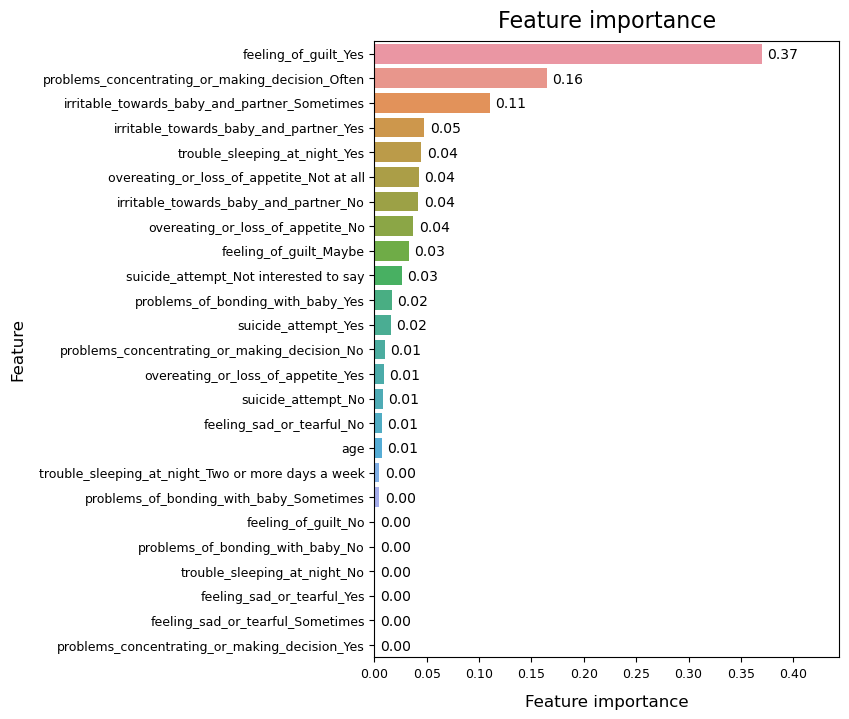

In [176]:
plot_feature_importance(dtc_feature_importance, dist=0.02)

### 6.3.2. Random Forest

In [177]:
# Instantiate model 
rfc = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_leaf=0.05, random_state=42)

# Fit model
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=0.05, random_state=42)

In [178]:
# Accuracy score: Evaluate model against training set 
rfc.score(X_train, y_train)

0.846089850249584

In [179]:
# Accuracy score: Evaluate model against testing set 
rfc.score(X_test, y_test)

0.840531561461794

**&rarr; Model is not over-fitted**

**Hyperparameter Tuning**

In [180]:
%%time

# Hyperparameter tuning
rfc = RandomForestClassifier(random_state=42)

param_grid = {
    'max_depth'        : range(3,8,1), 
    'min_samples_split': range(2,11,1),
    'min_samples_leaf' : [0.01, 0.05, 0.1], # in %
    'n_estimators'     : [50, 100, 200] 
    }

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# RandomizedSearchCV
# rfc_rs = RandomizedSearchCV(rfc, param_distributions=param_grid, n_iter=200, n_jobs=-1, cv=cv, verbose=0, random_state=42)
# rfc_rs.fit(X_train, y_train)

# GridSearchCV
rfc_gs = GridSearchCV(rfc, param_grid=param_grid, n_jobs=-1, cv=cv, verbose=0)
rfc_gs.fit(X_train, y_train)

CPU times: total: 10.6 s
Wall time: 1min 21s


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(3, 8),
                         'min_samples_leaf': [0.01, 0.05, 0.1],
                         'min_samples_split': range(2, 11),
                         'n_estimators': [50, 100, 200]})

In [181]:
# best_score_: Mean cross-validated score of the best_estimator
# best_params_: Parameter setting that gave the best results on the hold out data

print(rfc_gs.best_score_, rfc_gs.best_params_)

0.9026997245179065 {'max_depth': 6, 'min_samples_leaf': 0.01, 'min_samples_split': 2, 'n_estimators': 100}


In [182]:
# best_estimator_: Estimator which gave highest score on the hold out data
rfc_gs.best_estimator_

RandomForestClassifier(max_depth=6, min_samples_leaf=0.01, random_state=42)

In [183]:
# Accuracy score: Evaluate model against training set 
rfc_gs.score(X_train, y_train)

0.910981697171381

In [184]:
# Accuracy score: Evaluate model against testing set 
rfc_gs.score(X_test, y_test)

0.8704318936877077

In [185]:
# 5% range of training set accuracy
rfc_gs.score(X_train, y_train) - (rfc_gs.score(X_train, y_train) * 0.05)

0.865432612312812

**&rarr; Model might be on the edge of being over-fitted**

**Cross-Validation**

In [186]:
%%time 

# Cross-validation using best estimator
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
scores = cross_val_score(rfc_gs.best_estimator_, X_train, y_train, cv=cv, n_jobs=-1)

print(f'Scores:\n{scores}\n')
print(f'\033[1;3mRandom Forest; Cross-validation mean accuracy score and standard deviation: {scores.mean():.3f} +/-{scores.std():.3f}\033[0m')

Scores:
[0.89256198 0.8677686  0.925      0.9        0.90833333 0.94166667
 0.84166667 0.86666667 0.925      0.95833333 0.95041322 0.94214876
 0.91666667 0.925      0.925      0.825      0.86666667 0.9
 0.83333333 0.9        0.91735537 0.90909091 0.89166667 0.89166667
 0.90833333 0.90833333 0.88333333 0.90833333 0.89166667 0.89166667]

Random Forest; Cross-validation mean accuracy score and standard deviation: 0.900 +/-0.032
CPU times: total: 5.22 s
Wall time: 5.22 s


**Feature Importance**

The higher the value for feature importance, the more important the feature. The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the **Gini importance**

In [187]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=6, min_samples_split=2 , min_samples_leaf=0.01 , random_state=42)
rfc.fit(X_train, y_train)

# Compile feature importance 
rfc_feature_importance = pd.DataFrame(zip(X_train.columns, rfc.feature_importances_), columns=['feature', 'feature_importance']).sort_values(by='feature_importance', ascending=False)
rfc_feature_importance

feature  feature_importance
18                               feeling_of_guilt_Yes            0.210544
17                                feeling_of_guilt_No            0.117060
5        irritable_towards_baby_and_partner_Sometimes            0.074113
19                   problems_of_bonding_with_baby_No            0.063565
23              suicide_attempt_Not interested to say            0.061301
15                 overeating_or_loss_of_appetite_Yes            0.046101
10       problems_concentrating_or_making_decision_No            0.045637
16                             feeling_of_guilt_Maybe            0.044722
11    problems_concentrating_or_making_decision_Often            0.037012
6              irritable_towards_baby_and_partner_Yes            0.027997
13                  overeating_or_loss_of_appetite_No            0.024226
2                    feeling_sad_or_tearful_Sometimes            0.023500
4               irritable_towards_baby_and_partner_No            0.023364
9                       trouble_sleeping_at_night_Yes            0.021576
7                        trouble_sleeping_at_night_No            0.020001
8   trouble_sleeping_at_night_Two or more days a week            0.019006
12      problems_concentrating_or_making_decision_Yes            0.018199
3                          feeling_sad_or_tearful_Yes            0.017440
1                           feeling_sad_or_tearful_No            0.016681
24                                suicide_attempt_Yes            0.016217
22                                 suicide_attempt_No            0.015718
14          overeating_or_loss_of_appetite_Not at all            0.015455
20            problems_of_bonding_with_baby_Sometimes            0.014113
0                                                 age            0.013311
21                  problems_of_bonding_with_baby_Yes            0.013140

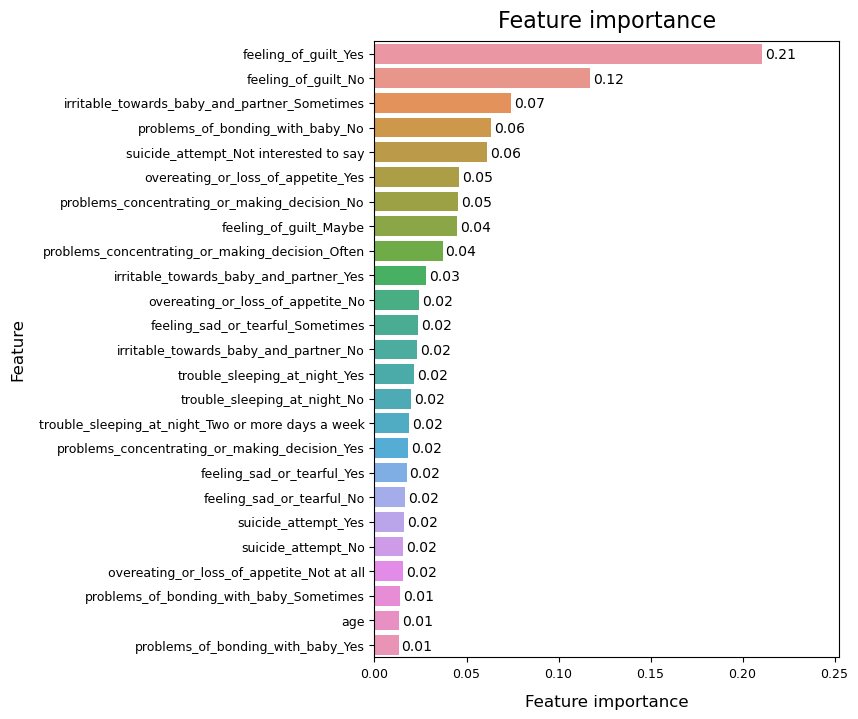

In [188]:
# Plot feature importance 
plot_feature_importance(rfc_feature_importance, dist=0.01)

### 6.3.3. AdaBoost

In [189]:
# Instantiate 
ada = AdaBoostClassifier(random_state=42)

# Fit
ada.fit(X_train, y_train)

AdaBoostClassifier(random_state=42)

In [190]:
# Accuracy score: Evaluate model against training set 
ada.score(X_train, y_train)

0.8211314475873545

In [191]:
# Accuracy score: Evaluate model against testing set 
ada.score(X_test, y_test)

0.8073089700996677

**&rarr; Model is not over-fitted**

**Hyperparameter Tuning**

In [192]:
%%time

# Hyperparameter tuning
ada = AdaBoostClassifier(random_state=42)

param_grid = {
    'n_estimators'     : [10, 50, 100, 200, 300, 400, 500],
    'learning_rate'    : [0.0001, 0.01, 0.1, 1.0, 1.5, 2]
    }

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# RandomizedSearchCV
# ada_rs = RandomizedSearchCV(ada, param_distributions=param_grid, n_iter=100, n_jobs=-1, cv=cv, verbose=0, random_state=42)
# ada_rs.fit(X_train, y_train)

# GridSearchCV
ada_gs = GridSearchCV(ada, param_grid=param_grid, n_jobs=-1, cv=cv, verbose=0)
ada_gs.fit(X_train, y_train)

CPU times: total: 1.8 s
Wall time: 20.3 s


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=AdaBoostClassifier(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.0001, 0.01, 0.1, 1.0, 1.5, 2],
                         'n_estimators': [10, 50, 100, 200, 300, 400, 500]})

In [193]:
# best_score_: Mean cross-validated score of the best_estimator
# best_params_: Parameter setting that gave the best results on the hold out data

print(ada_gs.best_score_, ada_gs.best_params_)

0.851935261707989 {'learning_rate': 0.01, 'n_estimators': 400}


In [194]:
# best_estimator_: Estimator which gave highest score on the hold out data
ada_gs.best_estimator_

AdaBoostClassifier(learning_rate=0.01, n_estimators=400, random_state=42)

In [195]:
# Accuracy score: Evaluate model against training set 
ada_gs.score(X_train, y_train)

0.8527454242928453

In [196]:
# Accuracy score: Evaluate model against testing set 
ada_gs.score(X_test, y_test)

0.8438538205980066

**&rarr; Model is not over-fitted**

**Cross-Validation**

In [197]:
%%time 

# Cross-validation using best estimator
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
scores = cross_val_score(ada_gs.best_estimator_, X_train, y_train, cv=cv, n_jobs=-1)

print(f'Scores:\n{scores}\n')
print(f'\033[1;3mAdaBoost; Cross-validation mean accuracy score and standard deviation: {scores.mean():.3f} +/-{scores.std():.3f}\033[0m')

Scores:
[0.84297521 0.83471074 0.85833333 0.85833333 0.84166667 0.86666667
 0.81666667 0.85833333 0.85833333 0.88333333 0.90909091 0.87603306
 0.88333333 0.86666667 0.84166667 0.8        0.81666667 0.83333333
 0.81666667 0.85       0.85950413 0.85950413 0.8        0.83333333
 0.875      0.84166667 0.81666667 0.875      0.84166667 0.85833333]

AdaBoost; Cross-validation mean accuracy score and standard deviation: 0.849 +/-0.025
CPU times: total: 23.7 s
Wall time: 23.7 s


**Feature Importance**

In [198]:
ada = AdaBoostClassifier(n_estimators=400, learning_rate=0.01, random_state=42)
ada.fit(X_train, y_train)

# Compile feature importance 
ada_feature_importance = pd.DataFrame(zip(X_train.columns, ada.feature_importances_), columns=['feature', 'feature_importance']).sort_values(by='feature_importance', ascending=False)
ada_feature_importance

feature  feature_importance
17                                feeling_of_guilt_No              0.2000
5        irritable_towards_baby_and_partner_Sometimes              0.1750
18                               feeling_of_guilt_Yes              0.1725
11    problems_concentrating_or_making_decision_Often              0.1375
23              suicide_attempt_Not interested to say              0.1275
19                   problems_of_bonding_with_baby_No              0.0875
15                 overeating_or_loss_of_appetite_Yes              0.0750
10       problems_concentrating_or_making_decision_No              0.0250
0                                                 age              0.0000
14          overeating_or_loss_of_appetite_Not at all              0.0000
22                                 suicide_attempt_No              0.0000
21                  problems_of_bonding_with_baby_Yes              0.0000
20            problems_of_bonding_with_baby_Sometimes              0.0000
16                             feeling_of_guilt_Maybe              0.0000
12      problems_concentrating_or_making_decision_Yes              0.0000
13                  overeating_or_loss_of_appetite_No              0.0000
1                           feeling_sad_or_tearful_No              0.0000
9                       trouble_sleeping_at_night_Yes              0.0000
8   trouble_sleeping_at_night_Two or more days a week              0.0000
7                        trouble_sleeping_at_night_No              0.0000
6              irritable_towards_baby_and_partner_Yes              0.0000
4               irritable_towards_baby_and_partner_No              0.0000
3                          feeling_sad_or_tearful_Yes              0.0000
2                    feeling_sad_or_tearful_Sometimes              0.0000
24                                suicide_attempt_Yes              0.0000

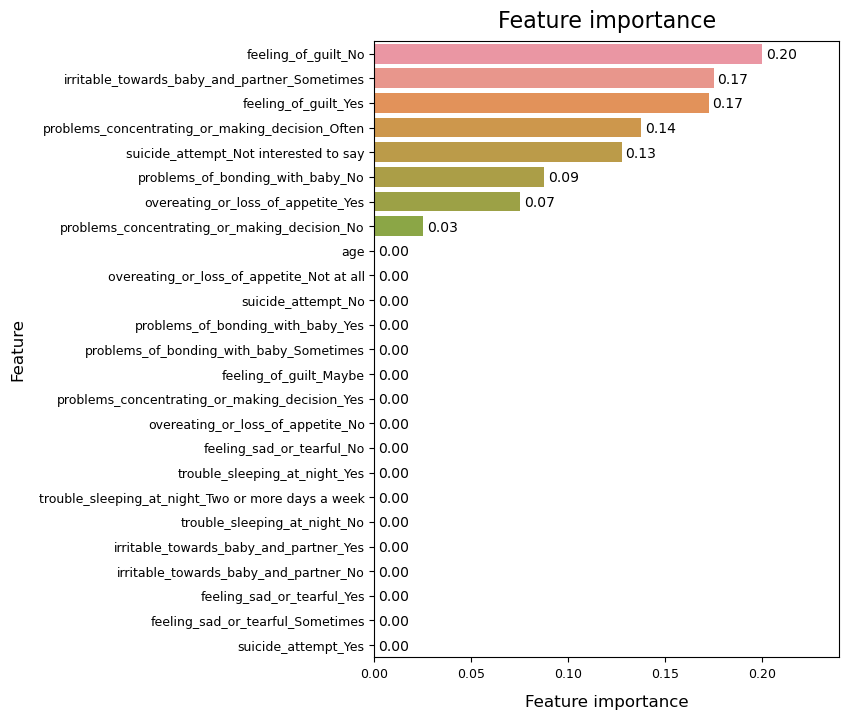

In [199]:
# Plot feature importance 
plot_feature_importance(ada_feature_importance, dist=0.01)

### 6.3.4. LightGBM

In [28]:
# Instantiate 
lgb = lightgbm.LGBMClassifier(random_state=42)

# Fit
lgb.fit(X_train, y_train)

LGBMClassifier(random_state=42)

In [29]:
# Accuracy score: Evaluate model against training set 
lgb.score(X_train, y_train)

1.0

In [30]:
# Accuracy score: Evaluate model against testing set 
lgb.score(X_test, y_test)

0.9933554817275747

**&rarr; Model is not over-fitted**

**Cross-Validation**

In [31]:
%%time 

# Cross-validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
scores = cross_val_score(lgb, X_train, y_train, cv=cv)

print(f'Scores:\n{scores}\n')
print(f'\033[1;3mLightGBM; Cross-validation mean accuracy score and standard deviation: {scores.mean():.3f} +/-{scores.std():.3f}\033[0m')

Scores:
[0.95867769 0.95041322 0.96666667 0.99166667 0.95833333 1.
 0.95833333 0.96666667 0.99166667 0.98333333 0.98347107 0.96694215
 0.975      0.96666667 0.98333333 0.94166667 1.         0.99166667
 0.975      0.95       0.95867769 0.99173554 0.98333333 0.975
 0.98333333 0.975      0.96666667 0.975      0.975      0.96666667]

LightGBM; Cross-validation mean accuracy score and standard deviation: 0.974 +/-0.015
CPU times: total: 25.8 s
Wall time: 1.68 s


**Learning Curves**

In [110]:
# Define datasets to evaluate each iteration
evalset = [(X_train, y_train), (X_test,y_test)]

# Model parameters (untuned model)
lgb = lightgbm.LGBMClassifier(n_estimators=150, random_state=42)

# Fit model
lgb.fit(X_train, y_train, eval_metric='logloss', eval_set=evalset, callbacks=[lightgbm.log_evaluation(0)])

LGBMClassifier(n_estimators=150, random_state=42)

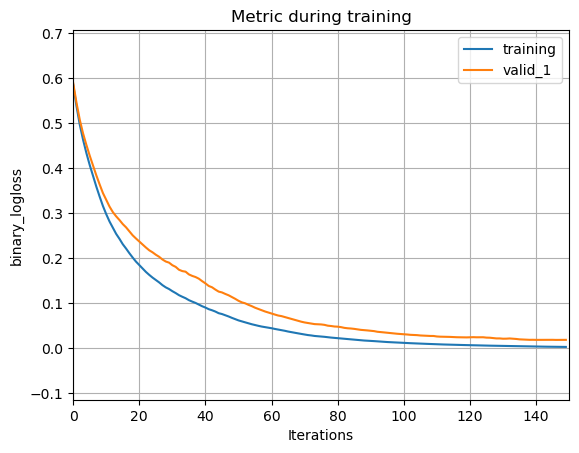

In [111]:
lightgbm.plot_metric(lgb);

**Hyperparameter Tuning**

In [112]:
%%time

# Hyperparameter tuning
lgb = lightgbm.LGBMClassifier(random_state=42)

param_grid = {
    'max_depth'       : range(2,11,1), # default -1
    'n_estimators'    : [100, 150], # default 100
    'learning_rate'   : [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5], # default 0.1
    'num_leaves'      : range(8,22,2), # default 31
    'subsample'       : [i/10.0 for i in range(3,11)], # default 1
    }

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# RandomizedSearchCV
lgb_rs = RandomizedSearchCV(lgb, param_distributions=param_grid, n_iter=3000, n_jobs=-1, cv=cv, verbose=0, random_state=42)
lgb_rs.fit(X_train, y_train)

CPU times: total: 18 s
Wall time: 55.9 s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=LGBMClassifier(random_state=42), n_iter=3000,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.2,
                                                          0.3, 0.4, 0.5],
                                        'max_depth': range(2, 11),
                                        'n_estimators': [100, 150],
                                        'num_leaves': range(8, 22, 2),
                                        'subsample': [0.3, 0.4, 0.5, 0.6, 0.7,
                                                      0.8, 0.9, 1.0]},
                   random_state=42)

In [113]:
# best_score_: Mean cross-validated score of the best_estimator
# best_params_: Parameter setting that gave the best results on the hold out data

print(lgb_rs.best_score_, lgb_rs.best_params_)

0.9692289073305671 {'subsample': 0.4, 'num_leaves': 10, 'max_depth': 6, 'learning_rate': 0.3}


In [114]:
# best_estimator_: Estimator which gave highest score on the hold out data
lgb_rs.best_estimator_

LGBMClassifier(learning_rate=0.3, max_depth=6, num_leaves=10, random_state=42,
               subsample=0.4)

In [126]:
# Accuracy score: Evaluate model against training set 
lgb_rs.score(X_train, y_train)

1.0

In [127]:
# Accuracy score: Evaluate model against testing set 
lgb_rs.score(X_test, y_test)

0.9933554817275747

**&rarr; Model is not over-fitted**

**Cross-Validation**

In [125]:
%%time 

# Cross-validation using best estimator
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
scores = cross_val_score(lgb_rs.best_estimator_, X_train, y_train, cv=cv)

print(f'Scores:\n{scores}\n')
print(f'\033[1;3mLightGBM; Cross-validation mean accuracy score and standard deviation: {scores.mean():.3f} +/-{scores.std():.3f}\033[0m')

Scores:
[0.96694215 0.95041322 0.96666667 0.98333333 0.96666667 1.
 0.96666667 0.96666667 0.99166667 0.99166667 0.99173554 0.96694215
 0.99166667 0.96666667 0.98333333 0.94166667 1.         0.99166667
 0.98333333 0.95       0.95867769 0.99173554 0.98333333 0.98333333
 0.98333333 0.975      0.96666667 0.975      0.975      0.96666667]

LightGBM; Cross-validation mean accuracy score and standard deviation: 0.976 +/-0.015
CPU times: total: 13 s
Wall time: 855 ms


**&rarr; Model performance improvement by hyperparameter tuning was miniscule**

**Learning Curves**

In [117]:
# Define datasets to evaluate each iteration
evalset = [(X_train, y_train), (X_test, y_test)]

# Model parameters (tuned model)
lgb = lightgbm.LGBMClassifier(learning_rate=0.3, max_depth=6, n_estimators=150, num_leaves=10, random_state=42, subsample=0.4, n_jobs=-1)

# Fit model
lgb.fit(X_train, y_train, eval_metric='logloss', eval_set=evalset, callbacks=[lightgbm.log_evaluation(0)])

LGBMClassifier(learning_rate=0.3, max_depth=6, n_estimators=150, num_leaves=10,
               random_state=42, subsample=0.4)

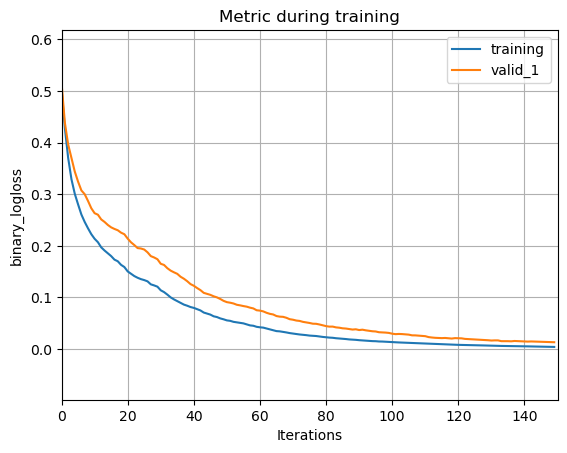

In [118]:
lightgbm.plot_metric(lgb);

In [119]:
# Retrieve performance metrics
results = lgb.evals_result_
results.keys()

dict_keys(['training', 'valid_1'])

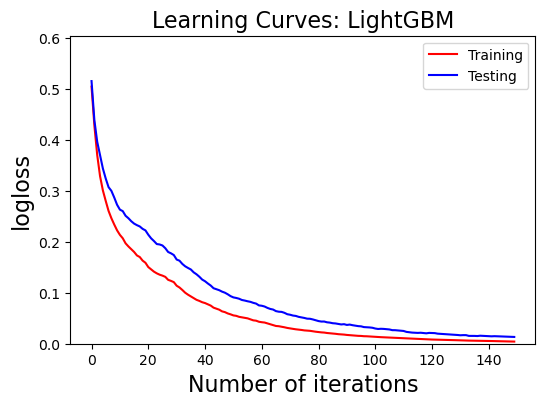

In [120]:
# Plot learning curves
learning_curve_lightgbm(results)

**Feature Importance**

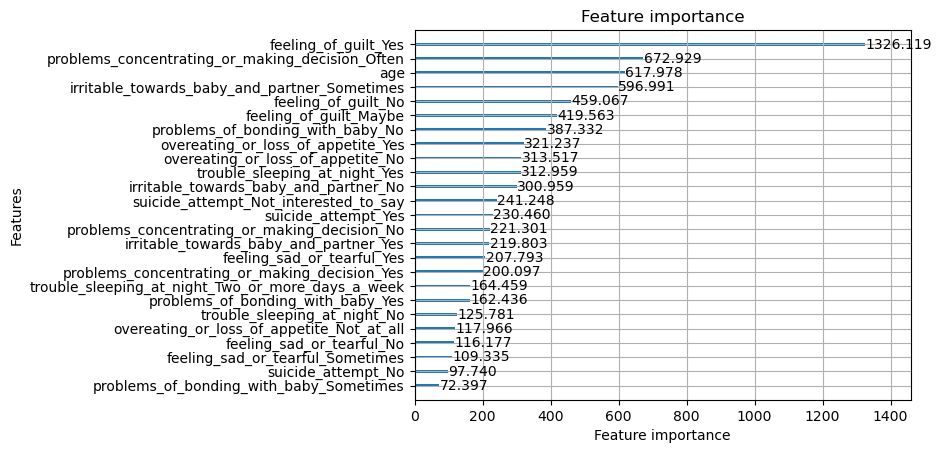

In [121]:
# Feature importance for untuned model
lgb = lightgbm.LGBMClassifier(random_state=42)
lgb.fit(X_train, y_train)

# Plot feature importance 
lightgbm.plot_importance(lgb, importance_type='gain');

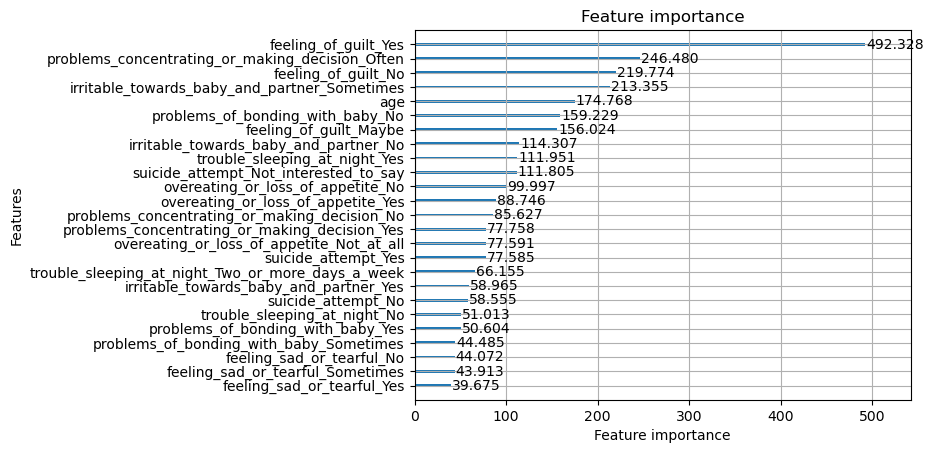

In [122]:
# Feature importance for tuned model
lgb = lightgbm.LGBMClassifier(learning_rate=0.3, max_depth=6, n_estimators=100, num_leaves=10, random_state=42, subsample=0.4, n_jobs=-1)
lgb.fit(X_train, y_train)

# Plot feature importance 
lightgbm.plot_importance(lgb, importance_type='gain');

In [123]:
# Retrieve feature importance 
imp = lgb.booster_.feature_importance(importance_type='gain')

# Compile feature importance in df
lgb_feature_importance = pd.DataFrame(zip(X_train.columns, imp), columns=['feature', 'feature_importance']).sort_values(by='feature_importance', ascending=False)
lgb_feature_importance

feature  feature_importance
18                               feeling_of_guilt_Yes          492.328087
11    problems_concentrating_or_making_decision_Often          246.479891
17                                feeling_of_guilt_No          219.774154
5        irritable_towards_baby_and_partner_Sometimes          213.354543
0                                                 age          174.768295
19                   problems_of_bonding_with_baby_No          159.229106
16                             feeling_of_guilt_Maybe          156.023912
4               irritable_towards_baby_and_partner_No          114.307270
9                       trouble_sleeping_at_night_Yes          111.950821
23              suicide_attempt_Not interested to say          111.805190
13                  overeating_or_loss_of_appetite_No           99.997444
15                 overeating_or_loss_of_appetite_Yes           88.746281
10       problems_concentrating_or_making_decision_No           85.627371
12      problems_concentrating_or_making_decision_Yes           77.757729
14          overeating_or_loss_of_appetite_Not at all           77.591462
24                                suicide_attempt_Yes           77.584877
8   trouble_sleeping_at_night_Two or more days a week           66.154943
6              irritable_towards_baby_and_partner_Yes           58.964555
22                                 suicide_attempt_No           58.555334
7                        trouble_sleeping_at_night_No           51.012609
21                  problems_of_bonding_with_baby_Yes           50.604244
20            problems_of_bonding_with_baby_Sometimes           44.485231
1                           feeling_sad_or_tearful_No           44.072130
2                    feeling_sad_or_tearful_Sometimes           43.912782
3                          feeling_sad_or_tearful_Yes           39.675052

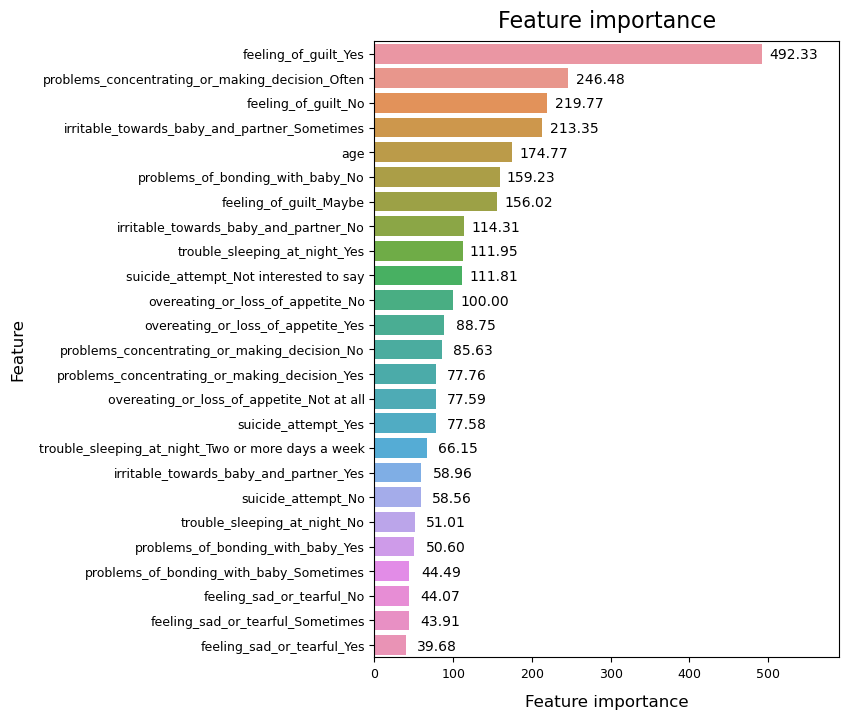

In [124]:
# Plot feature importance 
plot_feature_importance(lgb_feature_importance, dist=40)

**Tree**

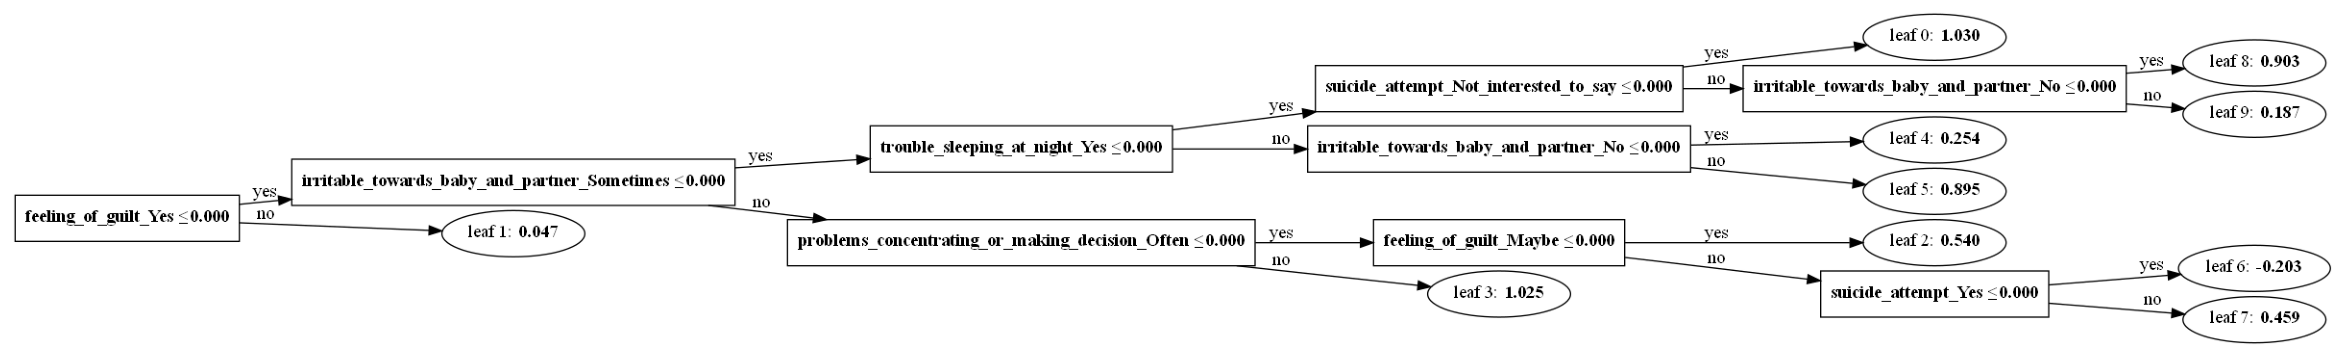

In [ ]:
# Plot tree
lightgbm.plot_tree(lgb,figsize=(30,40));

### 6.3.5. XGBoost

In [49]:
# Instantiate
xgb = xgboost.XGBClassifier(random_state=42)

# Fit
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [50]:
# Accuracy score: Evaluate model against training set 
xgb.score(X_train, y_train)

1.0

In [51]:
# Accuracy score: Evaluate model against testing set 
xgb.score(X_test, y_test)

0.9933554817275747

**&rarr; Model is not over-fitted**

**Cross-Validation**

In [52]:
%%time 

# Cross-validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
scores = cross_val_score(xgb, X_train, y_train, cv=cv)

print(f'Scores:\n{scores}\n')
print(f'\033[1;3mXGBoost; Cross-validation mean accuracy score and standard deviation: {scores.mean():.3f} +/-{scores.std():.3f}\033[0m')

Scores:
[0.97520661 0.95041322 0.96666667 0.98333333 0.975      1.
 0.975      0.95833333 0.99166667 0.98333333 0.98347107 0.98347107
 0.975      0.96666667 0.99166667 0.93333333 1.         0.975
 0.975      0.95       0.95041322 0.98347107 0.98333333 0.98333333
 0.98333333 0.975      0.95833333 0.96666667 0.975      0.95      ]

XGBoost; Cross-validation mean accuracy score and standard deviation: 0.973 +/-0.016
CPU times: total: 40.7 s
Wall time: 2.61 s


**Learning Curves**

In [53]:
# Define datasets to evaluate each iteration
evalset = [(X_train, y_train), (X_test,y_test)]

# Model parameters (untuned model)
xgb = xgboost.XGBClassifier(n_estimators=150, random_state=42) # n_estimators = iterations
xgb.set_params(eval_metric='logloss')

# Fit model
xgb.fit(X_train, y_train, eval_set=evalset, verbose=0)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=150,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [54]:
# Retrieve performance metrics
results = xgb.evals_result_
results.keys()

dict_keys(['validation_0', 'validation_1'])

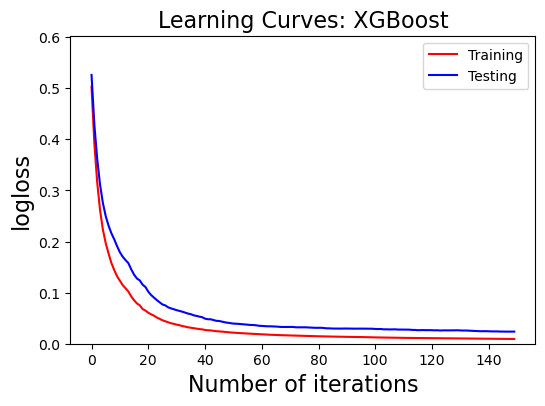

In [55]:
# Plot learning curves
learning_curve_xgboost(results)

**Hyperparameter Tuning**

In [132]:
%%time

# Hyperparameter tuning
xgb = xgboost.XGBClassifier(random_state=42)

param_grid = {
    'max_depth'       : range(3,11,1), # default 6
    'learning_rate'   : [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5], # default 0.3
    'min_child_weight': range(1,6,1), # default 1
    'subsample'       : [i/10.0 for i in range(3,11)], # default 1
    'colsample_bytree': [i/10.0 for i in range(3,11)] # default 1
    }

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# RandomizedSearchCV
xgb_rs = RandomizedSearchCV(xgb, param_distributions=param_grid, n_iter=2000, n_jobs=-1, cv=cv, verbose=0, random_state=42)
xgb_rs.fit(X_train, y_train)

CPU times: total: 24 s
Wall time: 1min 49s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importan...
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=42, ...),
                   n_iter=2000, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5, 0.6,
                                                             0.7, 0.8, 0.9,
                                                             1.0],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2,
                                                          0.3, 0.4, 0.5],
                                        'max_depth': range(3, 11),
                                        'min_child_weight': range(1, 6),
                                        'subsample': [0.3, 0.4, 0.5, 0.6, 0.7,
                                                      0.8, 0.9, 1.0]},
                   random_state=42)

In [133]:
# best_score_: Mean cross-validated score of the best_estimator
# best_params_: Parameter setting that gave the best results on the hold out data

print(xgb_rs.best_score_, xgb_rs.best_params_)

0.9675656984785614 {'subsample': 0.8, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.3, 'colsample_bytree': 0.7}


In [134]:
# best_estimator_: Estimator which gave highest score on the hold out data
xgb_rs.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.3, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [135]:
# Accuracy score: Evaluate model against training set 
xgb_rs.score(X_train, y_train)

1.0

In [136]:
# Accuracy score: Evaluate model against testing set 
xgb_rs.score(X_test, y_test)

1.0

**&rarr; Model is not over-fitted**

**Cross-Validation**

In [137]:
%%time 

# Cross-validation using best estimator
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
scores = cross_val_score(xgb_rs.best_estimator_, X_train, y_train, cv=cv)

print(f'Scores:\n{scores}\n')
print(f'\033[1;3mXGBoost; Cross-validation mean accuracy score and standard deviation: {scores.mean():.3f} +/-{scores.std():.3f}\033[0m')

Scores:
[0.97520661 0.95041322 0.98333333 0.98333333 0.95833333 0.99166667
 0.96666667 0.96666667 0.99166667 0.98333333 0.98347107 0.98347107
 0.975      0.95833333 0.98333333 0.94166667 1.         0.99166667
 0.96666667 0.95       0.95867769 0.98347107 0.975      0.98333333
 0.98333333 0.975      0.96666667 0.975      0.975      0.95833333]

XGBoost; Cross-validation mean accuracy score and standard deviation: 0.974 +/-0.014
CPU times: total: 42.5 s
Wall time: 2.73 s


**&rarr; Model performance improvement by hyperparameter tuning was miniscule**

**Learning Curves**

In [139]:
# Define datasets to evaluate each iteration
evalset = [(X_train, y_train), (X_test, y_test)]

# Model parameters (tuned model)
xgb = xgboost.XGBClassifier(n_estimators=150,
                            colsample_bytree=0.7,
                            subsample=0.8, 
                            learning_rate=0.3, 
                            max_depth=6, 
                            min_child_weight=1, 
                            n_jobs=-1,
                            random_state=42)

xgb.set_params(eval_metric='logloss')

# Fit model
xgb.fit(X_train, y_train, eval_set=evalset, verbose=0)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.3, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=150, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [140]:
# Retrieve performance metrics
results = xgb.evals_result_
results.keys()

dict_keys(['validation_0', 'validation_1'])

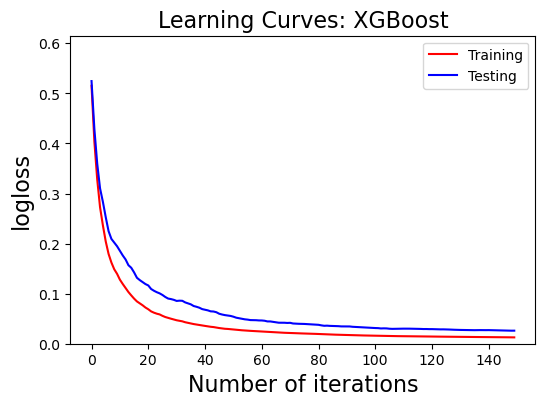

In [141]:
# Plot learning curves
learning_curve_xgboost(results)

**Feature Importance**

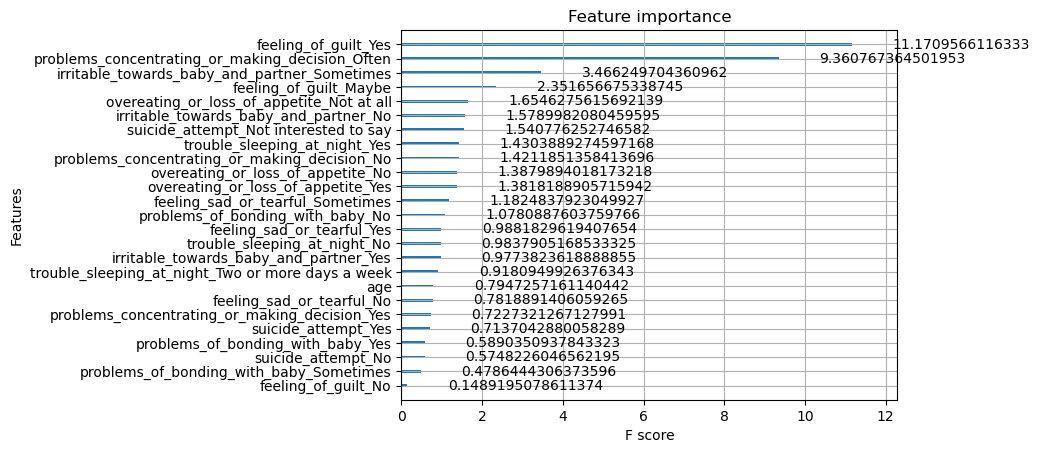

In [142]:
# Feature importance for untuned model
xgb = xgboost.XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)

# Plot feature importance 
xgboost.plot_importance(xgb, importance_type='gain');

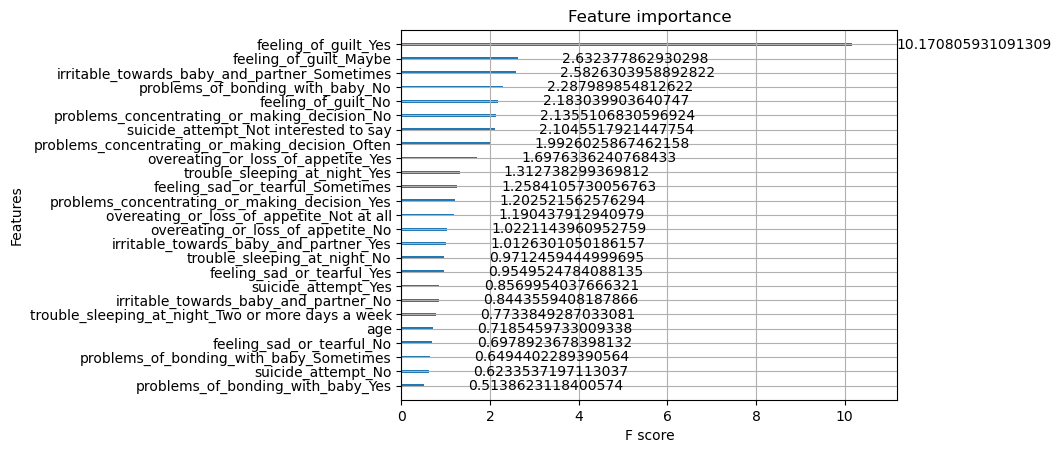

In [143]:
# Feature importance for tuned model
xgb = xgboost.XGBClassifier(n_estimators=100,
                            colsample_bytree=0.7,
                            subsample=0.8, 
                            learning_rate=0.3, 
                            max_depth=6, 
                            min_child_weight=1, 
                            n_jobs=-1,
                            random_state=42)

xgb.fit(X_train, y_train)

# Plot feature importance 
xgboost.plot_importance(xgb, importance_type='gain');

In [144]:
# Retrieve feature importance 
feature_imp = xgb.get_booster().get_score(importance_type="gain")
keys = feature_imp.keys()
values = feature_imp.values()

# Compile feature importance in df
xgb_feature_importance = pd.DataFrame(zip(keys, values), columns=['feature', 'feature_importance']).sort_values(by='feature_importance', ascending=False)
xgb_feature_importance

feature  feature_importance
18                               feeling_of_guilt_Yes           10.170806
16                             feeling_of_guilt_Maybe            2.632378
5        irritable_towards_baby_and_partner_Sometimes            2.582630
19                   problems_of_bonding_with_baby_No            2.287990
17                                feeling_of_guilt_No            2.183040
10       problems_concentrating_or_making_decision_No            2.135511
23              suicide_attempt_Not interested to say            2.104552
11    problems_concentrating_or_making_decision_Often            1.992603
15                 overeating_or_loss_of_appetite_Yes            1.697634
9                       trouble_sleeping_at_night_Yes            1.312738
2                    feeling_sad_or_tearful_Sometimes            1.258411
12      problems_concentrating_or_making_decision_Yes            1.202522
14          overeating_or_loss_of_appetite_Not at all            1.190438
13                  overeating_or_loss_of_appetite_No            1.022114
6              irritable_towards_baby_and_partner_Yes            1.012630
7                        trouble_sleeping_at_night_No            0.971246
3                          feeling_sad_or_tearful_Yes            0.954952
24                                suicide_attempt_Yes            0.856995
4               irritable_towards_baby_and_partner_No            0.844356
8   trouble_sleeping_at_night_Two or more days a week            0.773385
0                                                 age            0.718546
1                           feeling_sad_or_tearful_No            0.697892
20            problems_of_bonding_with_baby_Sometimes            0.649440
22                                 suicide_attempt_No            0.623354
21                  problems_of_bonding_with_baby_Yes            0.513862

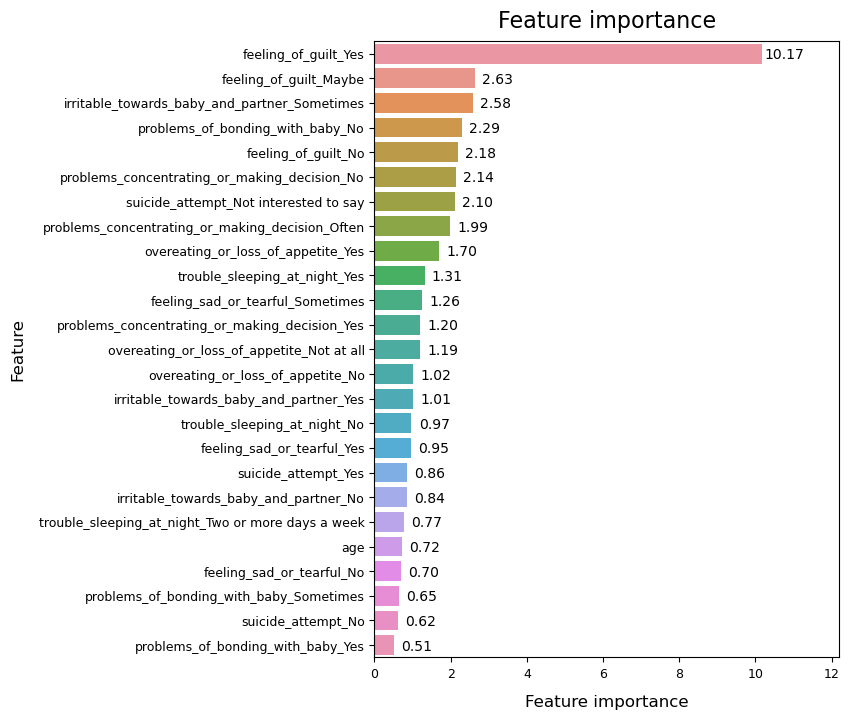

In [147]:
# Plot feature importance 
plot_feature_importance(xgb_feature_importance, dist=0.6)

**Tree**

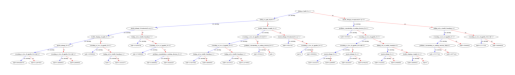

In [80]:
# Plot tree
xgboost.plot_tree(xgb,figsize=(30,40));

### 6.3.6. CatBoost

In [148]:
# Instantiate
cbc = catboost.CatBoostClassifier(verbose=0, random_state=42)

# Fit
cbc.fit(X_train, y_train)

In [149]:
# Accuracy score: Evaluate model against training set 
cbc.score(X_train, y_train)

1.0

In [150]:
# Accuracy score: Evaluate model against testing set 
cbc.score(X_test, y_test)

1.0

**&rarr; Model is not over-fitted**

**Cross-Validation**

In [151]:
%%time 

# Cross-validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
scores = cross_val_score(cbc, X_train, y_train, cv=cv, n_jobs=-1)

print(f'Scores:\n{scores}\n')
print(f'\033[1;3mCatBoost; Cross-validation mean accuracy score and standard deviation: {scores.mean():.3f} +/-{scores.std():.3f}\033[0m')

Scores:
[0.97520661 0.95041322 0.96666667 0.98333333 0.96666667 1.
 0.96666667 0.96666667 1.         0.99166667 0.98347107 0.98347107
 0.98333333 0.96666667 0.98333333 0.94166667 1.         0.975
 0.98333333 0.95833333 0.97520661 0.98347107 0.98333333 0.98333333
 0.99166667 0.98333333 0.98333333 0.975      0.98333333 0.96666667]

CatBoost; Cross-validation mean accuracy score and standard deviation: 0.978 +/-0.013
CPU times: total: 156 ms
Wall time: 29.9 s


**Learning Curves**

In [152]:
# Define datasets to evaluate each iteration
evalset = [(X_train, y_train), (X_test, y_test)]

# Model parameters (untuned model)
cbc = catboost.CatBoostClassifier(random_state=42) # default iterations (= n_estimators): 500

# Fit model
cbc.fit(X_train, y_train, eval_set=evalset, use_best_model=True, verbose=0) # default loss function: Logloss

# Note! If parameter 'use_best_model' is set to True, the validation dataset is used to identify the optimal number of trees.
# Also, the 'use_best_model' parameter automatically defaults to True if a validation set is input (eval_set)

In [153]:
# Retrieve performance metrics
results = cbc.evals_result_
results.keys()

dict_keys(['learn', 'validation_0', 'validation_1'])

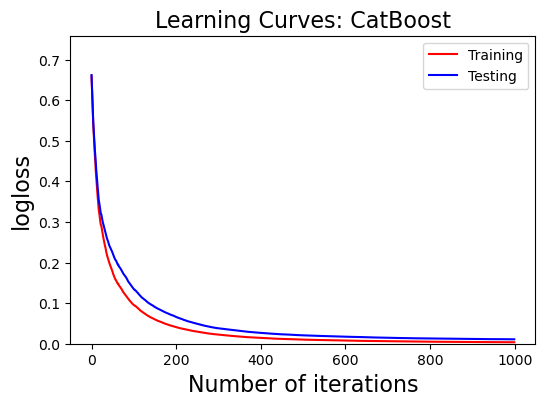

In [154]:
# Plot learning curves
learning_curve_catboost(results)

**Hyperparameter Tuning**

In [155]:
%%time

# Hyperparameter tuning
cbc = catboost.CatBoostClassifier(verbose=0, random_state=42)

# Note! By default, the learning rate is defined automatically based on the dataset properties and the number of iterations. 
# The automatically defined value should be close to the optimal one

param_grid = {
    'max_depth'       : range(3,11,1), # default 6
    'learning_rate'   : [0.01, 0.02, 0.03, 0.04], # default 0.03
    'iterations'      : [300, 400, 500, 1000] # default 500
    }

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# RandomizedSearchCV
cbc_rs = RandomizedSearchCV(cbc, param_distributions=param_grid, n_iter=40, n_jobs=-1, cv=cv, verbose=0, random_state=42)
cbc_rs.fit(X_train, y_train)

CPU times: total: 15.3 s
Wall time: 1min 59s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x0000026EB0FE2970>,
                   n_iter=40, n_jobs=-1,
                   param_distributions={'iterations': [300, 400, 500, 1000],
                                        'learning_rate': [0.01, 0.02, 0.03,
                                                          0.04],
                                        'max_depth': range(3, 11)},
                   random_state=42)

In [156]:
# best_score_: Mean cross-validated score of the best_estimator
# best_params_: Parameter setting that gave the best results on the hold out data

print(cbc_rs.best_score_, cbc_rs.best_params_)

0.9733921161825727 {'max_depth': 7, 'learning_rate': 0.03, 'iterations': 500}


In [157]:
# best_estimator_: Estimator which gave highest score on the hold out data
cbc_rs.best_estimator_

In [158]:
# Accuracy score: Evaluate model against training set 
cbc_rs.score(X_train, y_train)

1.0

In [159]:
# Accuracy score: Evaluate model against testing set 
cbc_rs.score(X_test, y_test)

1.0

**&rarr; Model is not over-fitted**

**Cross-Validation**

In [160]:
%%time 

# Cross-validation using best estimator
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
scores = cross_val_score(cbc_rs.best_estimator_, X_train, y_train, cv=cv, n_jobs=-1)

print(f'Scores:\n{scores}\n')
print(f'\033[1;3mCatBoost; Cross-validation mean accuracy score and standard deviation: {scores.mean():.3f} +/-{scores.std():.3f}\033[0m')

Scores:
[0.98347107 0.94214876 0.96666667 0.98333333 0.96666667 1.
 0.96666667 0.98333333 1.         1.         0.98347107 0.98347107
 0.98333333 0.975      0.98333333 0.94166667 1.         0.98333333
 0.98333333 0.95833333 0.97520661 0.98347107 0.98333333 0.98333333
 0.99166667 0.975      0.98333333 0.96666667 0.98333333 0.975     ]

CatBoost; Cross-validation mean accuracy score and standard deviation: 0.979 +/-0.014
CPU times: total: 78.1 ms
Wall time: 14.7 s


**&rarr; Model performance improvement by hyperparameter tuning was miniscule**

**Learning Curves**

In [161]:
# Define datasets to evaluate each iteration
evalset = [(X_train, y_train), (X_test, y_test)]

# Model parameters (tuned model)
cbc = catboost.CatBoostClassifier(iterations=500, learning_rate=0.03, max_depth=7, random_state=42, loss_function='Logloss')

# Fit model
cbc.fit(X_train, y_train, eval_set=evalset, verbose=0)

In [162]:
# Retrieve performance metrics
results = cbc.evals_result_
results.keys()

dict_keys(['learn', 'validation_0', 'validation_1'])

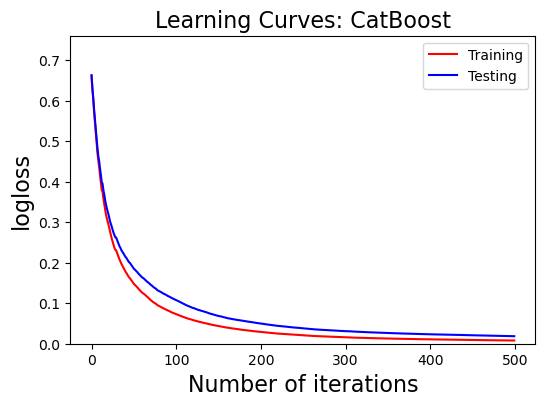

In [163]:
# Plot learning curves
learning_curve_catboost(results)

**Feature Importance**

In [164]:
cbc = catboost.CatBoostClassifier(iterations=500, learning_rate=0.03, max_depth=7, random_state=42, loss_function='Logloss')
cbc.fit(X_train, y_train, verbose=0)

# Compile feature importance
cbc_feature_importance = pd.DataFrame(zip(X_train.columns, cbc.feature_importances_), columns=['feature', 'feature_importance']).sort_values(by='feature_importance', ascending=False)
cbc_feature_importance

feature  feature_importance
18                               feeling_of_guilt_Yes           11.613357
17                                feeling_of_guilt_No            7.444379
0                                                 age            6.705319
5        irritable_towards_baby_and_partner_Sometimes            5.729612
10       problems_concentrating_or_making_decision_No            5.584736
19                   problems_of_bonding_with_baby_No            4.924223
9                       trouble_sleeping_at_night_Yes            4.856633
15                 overeating_or_loss_of_appetite_Yes            4.467732
23              suicide_attempt_Not interested to say            3.389204
4               irritable_towards_baby_and_partner_No            3.380810
11    problems_concentrating_or_making_decision_Often            3.340671
22                                 suicide_attempt_No            3.337153
3                          feeling_sad_or_tearful_Yes            3.323367
12      problems_concentrating_or_making_decision_Yes            3.267722
6              irritable_towards_baby_and_partner_Yes            3.077966
8   trouble_sleeping_at_night_Two or more days a week            3.040208
13                  overeating_or_loss_of_appetite_No            3.031724
2                    feeling_sad_or_tearful_Sometimes            2.986646
14          overeating_or_loss_of_appetite_Not at all            2.878379
7                        trouble_sleeping_at_night_No            2.693066
24                                suicide_attempt_Yes            2.599640
16                             feeling_of_guilt_Maybe            2.346675
1                           feeling_sad_or_tearful_No            2.226991
21                  problems_of_bonding_with_baby_Yes            1.974853
20            problems_of_bonding_with_baby_Sometimes            1.778933

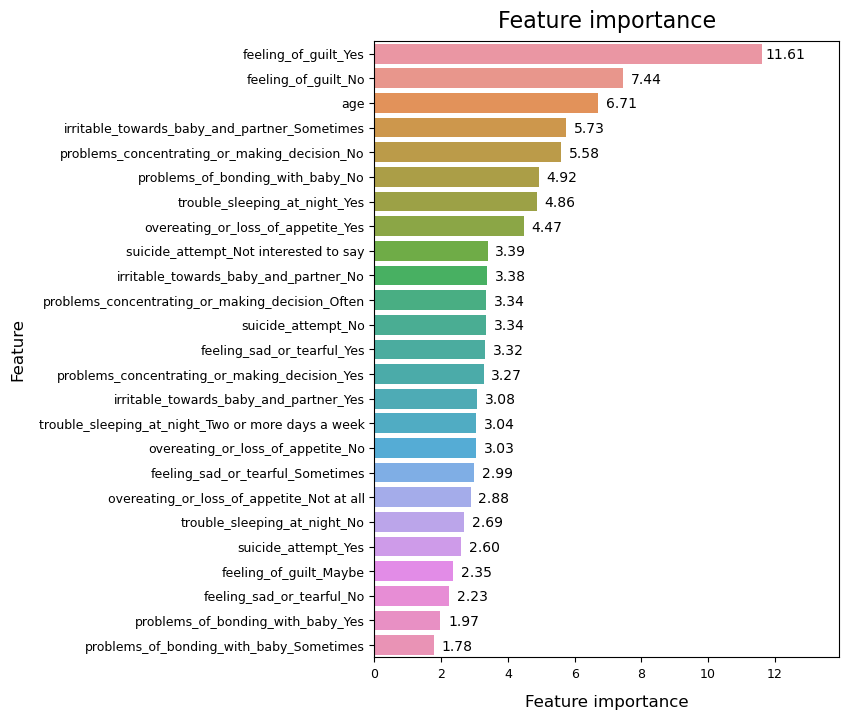

In [165]:
# Plot feature importance
plot_feature_importance(cbc_feature_importance, dist=0.7)

### 6.3.7. Model evaluation

#### Evaluation of tree-based models on training data


Decision Tree

Summary Report
Accuracy:  0.90 [TP / N] Proportion of predicted labels that match true labels
Precision: 0.90 [TP / (TP + FP)] Ability of the classifier not to label as positive a sample that is negative
Recall:    0.94 [TP / (TP + FN)] Ability of the classifier to find all positive samples
F1-score:  0.92 [F1 = 2 * (precision * recall) / (precision + recall)] Harmonic mean of the precision and recall
ROC AUC:   0.88
-----------------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples
----------------------------------------------------------------------------------------------------------------- 



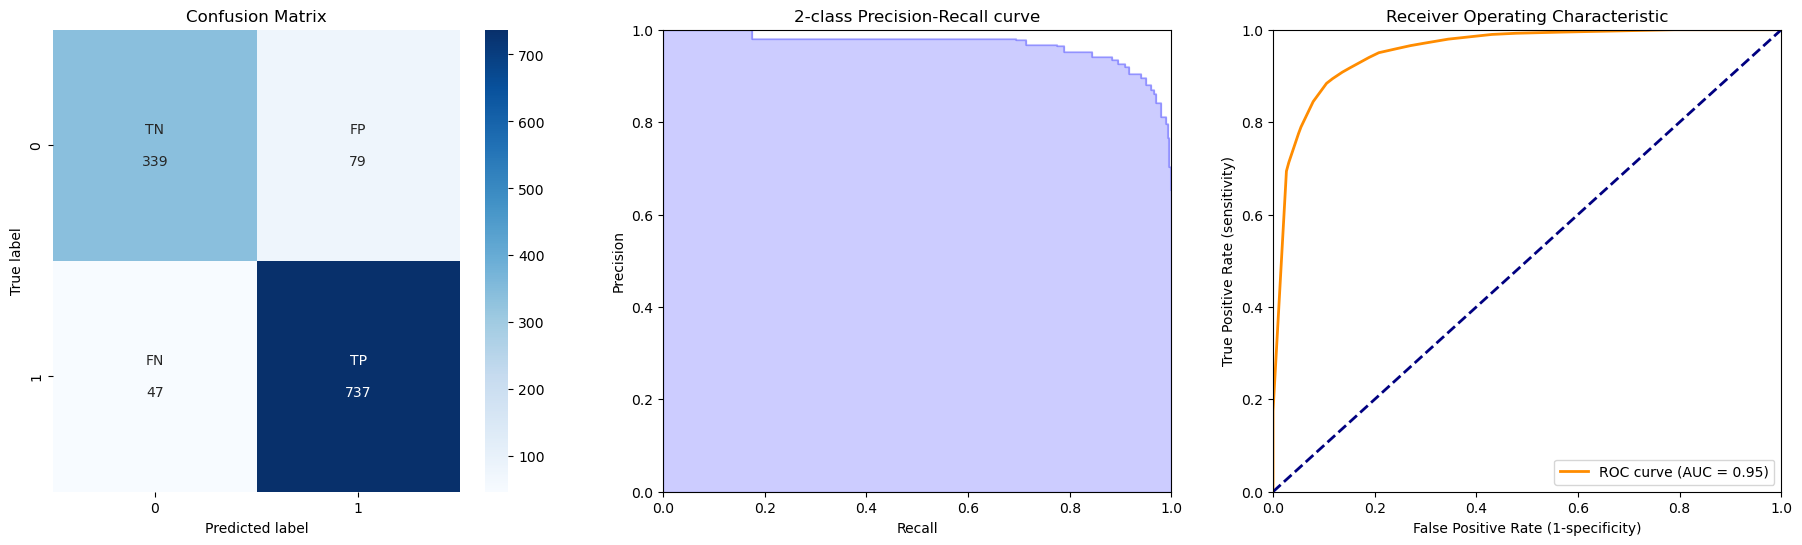


Random Forest

Summary Report
Accuracy:  0.91 [TP / N] Proportion of predicted labels that match true labels
Precision: 0.92 [TP / (TP + FP)] Ability of the classifier not to label as positive a sample that is negative
Recall:    0.94 [TP / (TP + FN)] Ability of the classifier to find all positive samples
F1-score:  0.93 [F1 = 2 * (precision * recall) / (precision + recall)] Harmonic mean of the precision and recall
ROC AUC:   0.90
-----------------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples
----------------------------------------------------------------------------------------------------------------- 



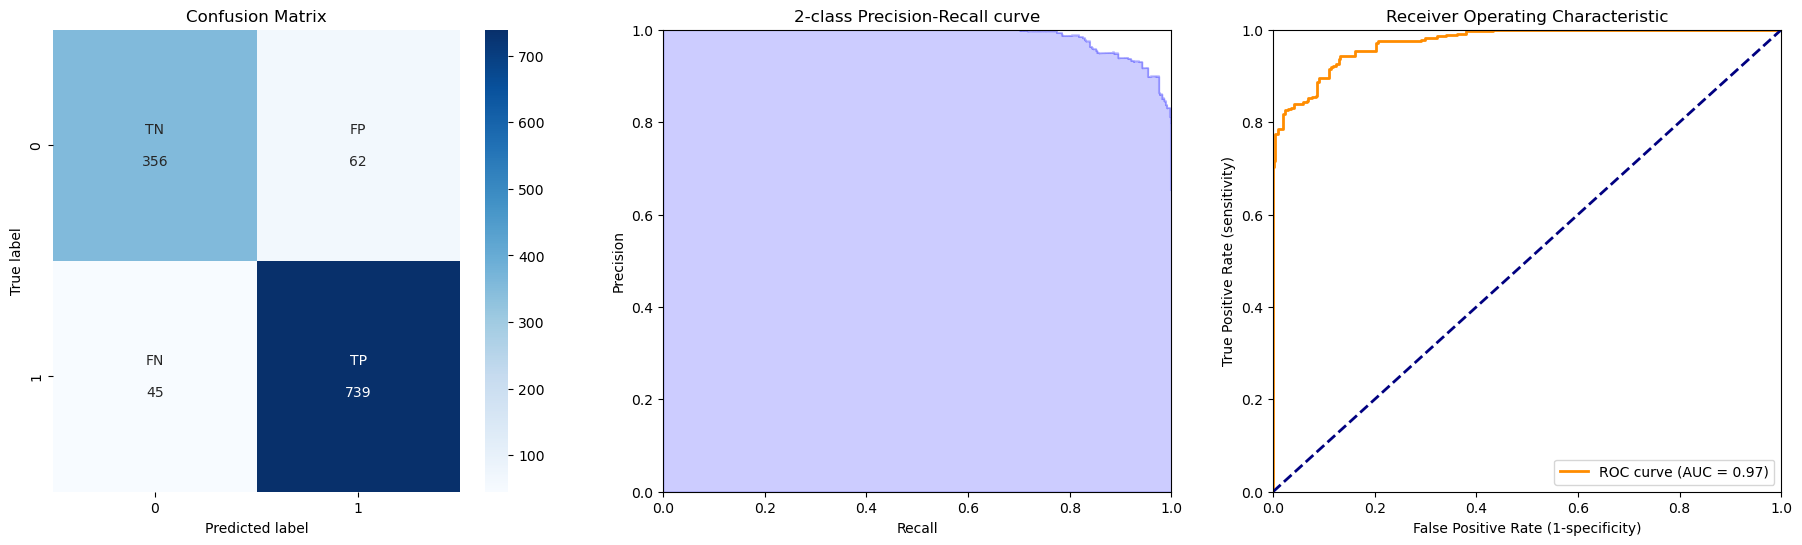


AdaBoost

Summary Report
Accuracy:  0.85 [TP / N] Proportion of predicted labels that match true labels
Precision: 0.86 [TP / (TP + FP)] Ability of the classifier not to label as positive a sample that is negative
Recall:    0.93 [TP / (TP + FN)] Ability of the classifier to find all positive samples
F1-score:  0.89 [F1 = 2 * (precision * recall) / (precision + recall)] Harmonic mean of the precision and recall
ROC AUC:   0.82
-----------------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples
----------------------------------------------------------------------------------------------------------------- 



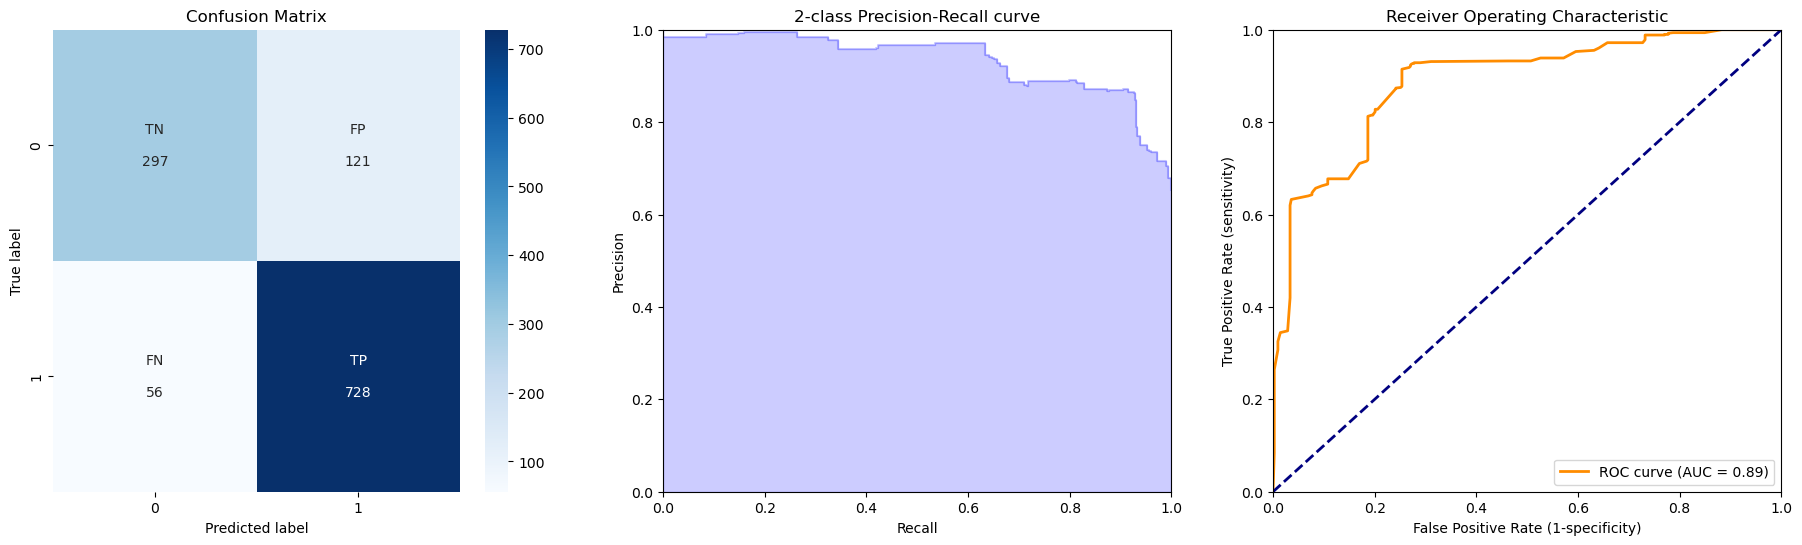


LightGBM

Summary Report
Accuracy:  1.00 [TP / N] Proportion of predicted labels that match true labels
Precision: 1.00 [TP / (TP + FP)] Ability of the classifier not to label as positive a sample that is negative
Recall:    1.00 [TP / (TP + FN)] Ability of the classifier to find all positive samples
F1-score:  1.00 [F1 = 2 * (precision * recall) / (precision + recall)] Harmonic mean of the precision and recall
ROC AUC:   1.00
-----------------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples
----------------------------------------------------------------------------------------------------------------- 



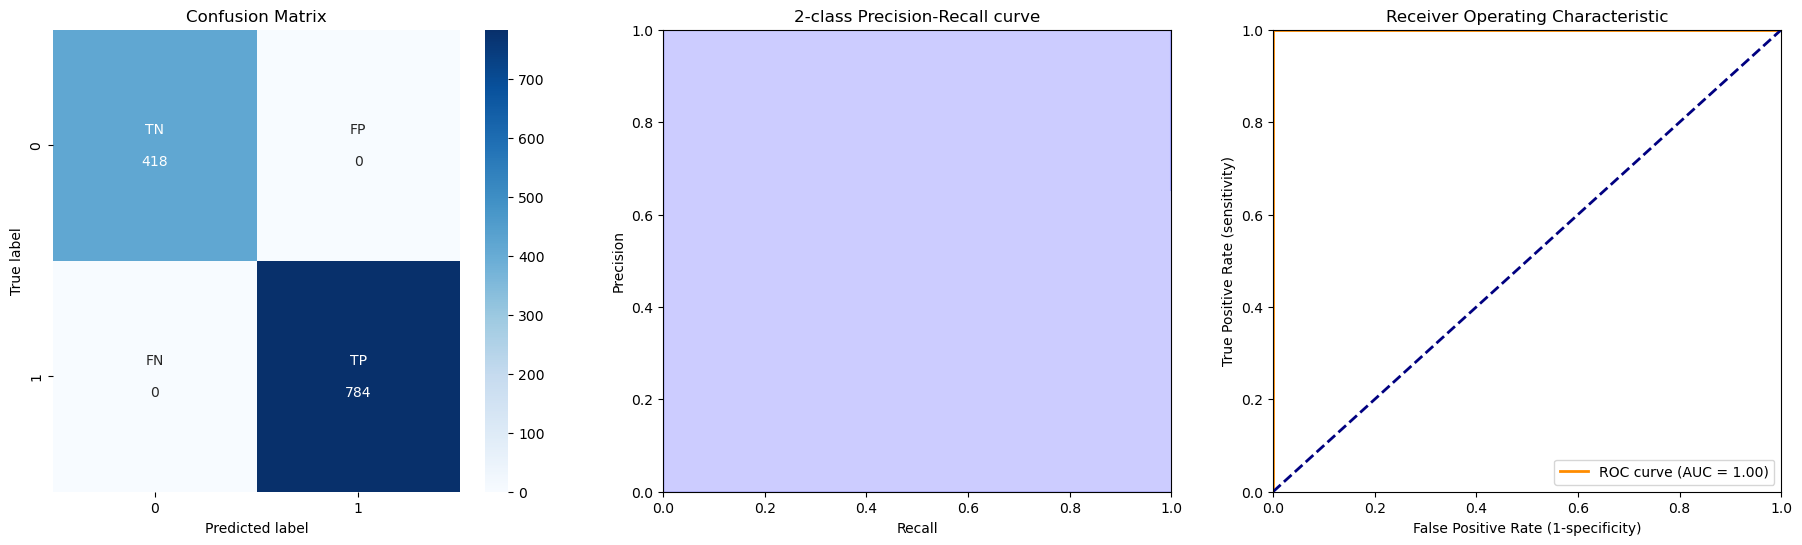


XGBoost

Summary Report
Accuracy:  1.00 [TP / N] Proportion of predicted labels that match true labels
Precision: 1.00 [TP / (TP + FP)] Ability of the classifier not to label as positive a sample that is negative
Recall:    1.00 [TP / (TP + FN)] Ability of the classifier to find all positive samples
F1-score:  1.00 [F1 = 2 * (precision * recall) / (precision + recall)] Harmonic mean of the precision and recall
ROC AUC:   1.00
-----------------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples
----------------------------------------------------------------------------------------------------------------- 



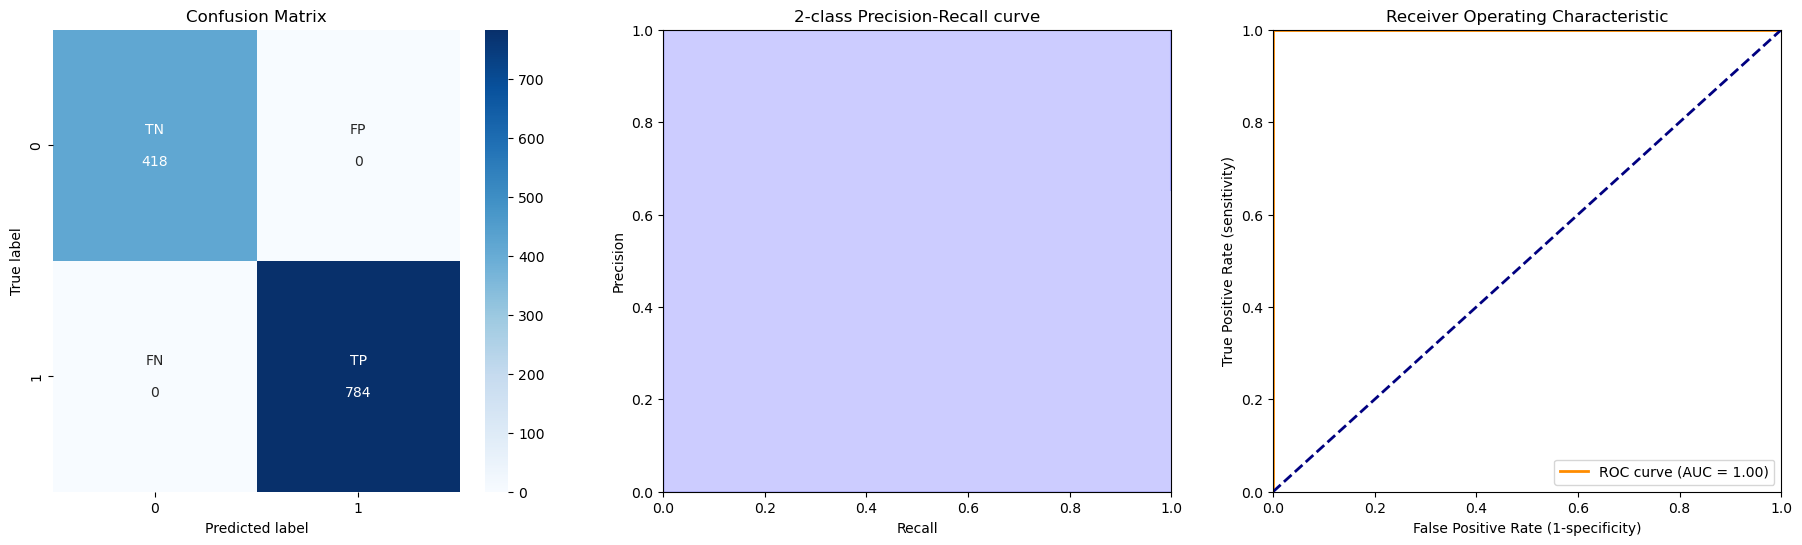


CatBoost

Summary Report
Accuracy:  1.00 [TP / N] Proportion of predicted labels that match true labels
Precision: 1.00 [TP / (TP + FP)] Ability of the classifier not to label as positive a sample that is negative
Recall:    1.00 [TP / (TP + FN)] Ability of the classifier to find all positive samples
F1-score:  1.00 [F1 = 2 * (precision * recall) / (precision + recall)] Harmonic mean of the precision and recall
ROC AUC:   1.00
-----------------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples
----------------------------------------------------------------------------------------------------------------- 



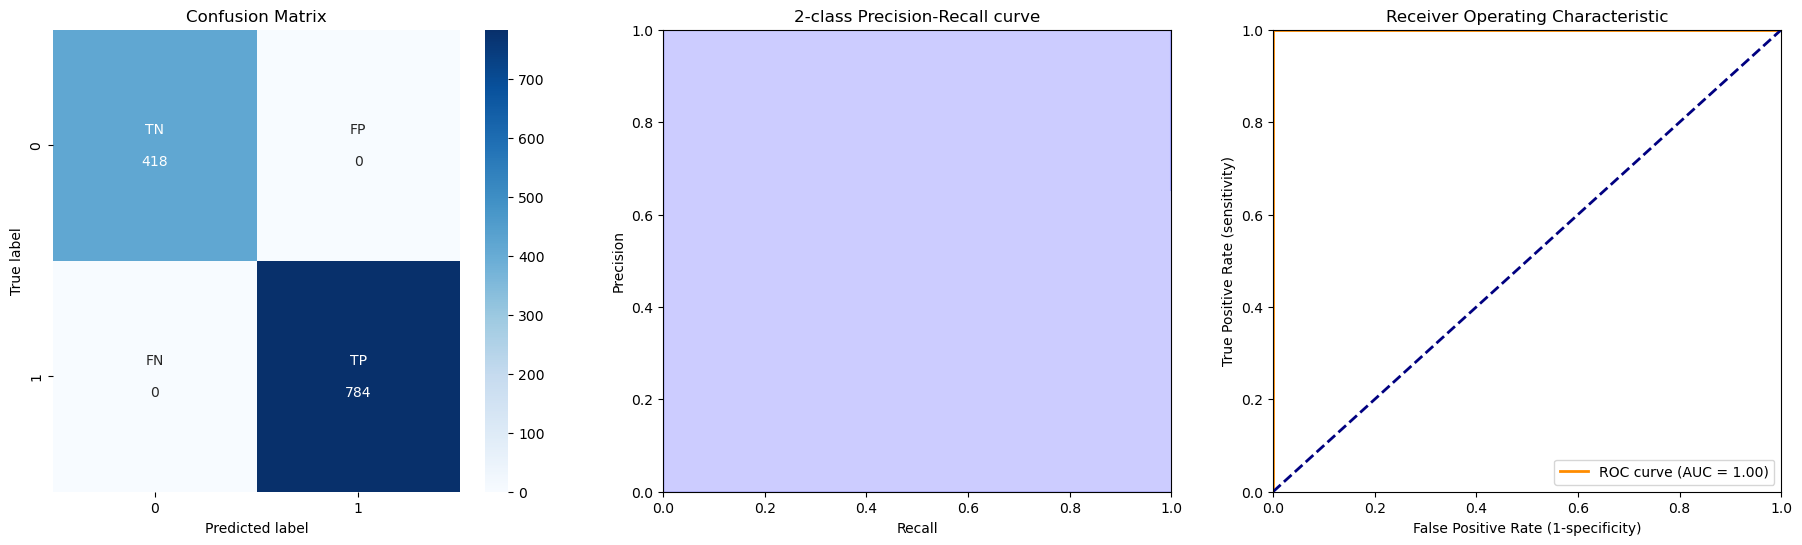

Model    Set  Accuracy  Precision  Recall  F1-score  ROC_AUC
2       AdaBoost  Train     0.853      0.857   0.929     0.892    0.820
5       CatBoost  Train     1.000      1.000   1.000     1.000    1.000
0  Decision Tree  Train     0.895      0.903   0.940     0.921    0.876
3       LightGBM  Train     1.000      1.000   1.000     1.000    1.000
1  Random Forest  Train     0.911      0.923   0.943     0.932    0.897
4        XGBoost  Train     1.000      1.000   1.000     1.000    1.000

In [200]:
## Print summary report including all plots and combine performance indicators of all models in a dataframe

# Create empty df with column headers
column_names = ['Model', 'Set', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC_AUC']
results_train = pd.DataFrame(columns=column_names)

# Model names
# models = ['Decision Tree_train', 'Random Forest_train', 'Bagging_train', 'AdaBoost_train', 'XGBoost_train', 'CatBoost_train']
models = ['Decision Tree', 'Random Forest', 'AdaBoost', 'LightGBM', 'XGBoost', 'CatBoost']

# Iterate through models
for i, m in enumerate([dtc_gs.best_estimator_, rfc_gs.best_estimator_, ada_gs.best_estimator_, lgb_rs.best_estimator_, xgb_rs.best_estimator_, cbc_rs.best_estimator_]):
    print(f'\n\033[1m{Fore.BLUE}{models[i]}{Style.RESET_ALL}\033[0m\n')
    
    # Summary report
    accuracy_, precision_, recall_, f1_, roc_auc_ = summary_report_tree(m, X_train, y_train)
    
    # Round values
    list = [accuracy_, precision_, recall_, f1_, roc_auc_]
    accuracy_, precision_, recall_, f1_, roc_auc_ = [round(x, 3) for x in list]
    
    # Add results to df
    results_train.loc[i] = {'Model': models[i], 'Set': 'Train', 'Accuracy': accuracy_, 'Precision': precision_,
                            'Recall': recall_, 'F1-score': f1_, 'ROC_AUC': roc_auc_}    

# Print dataframe with performance indicators for all models
print('\n')
results_train.sort_values(by='Model')

#### Evaluation of tree-based models on testing data


Decision Tree

Summary Report
Accuracy:  0.88 [TP / N] Proportion of predicted labels that match true labels
Precision: 0.90 [TP / (TP + FP)] Ability of the classifier not to label as positive a sample that is negative
Recall:    0.91 [TP / (TP + FN)] Ability of the classifier to find all positive samples
F1-score:  0.91 [F1 = 2 * (precision * recall) / (precision + recall)] Harmonic mean of the precision and recall
ROC AUC:   0.86
-----------------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples
----------------------------------------------------------------------------------------------------------------- 



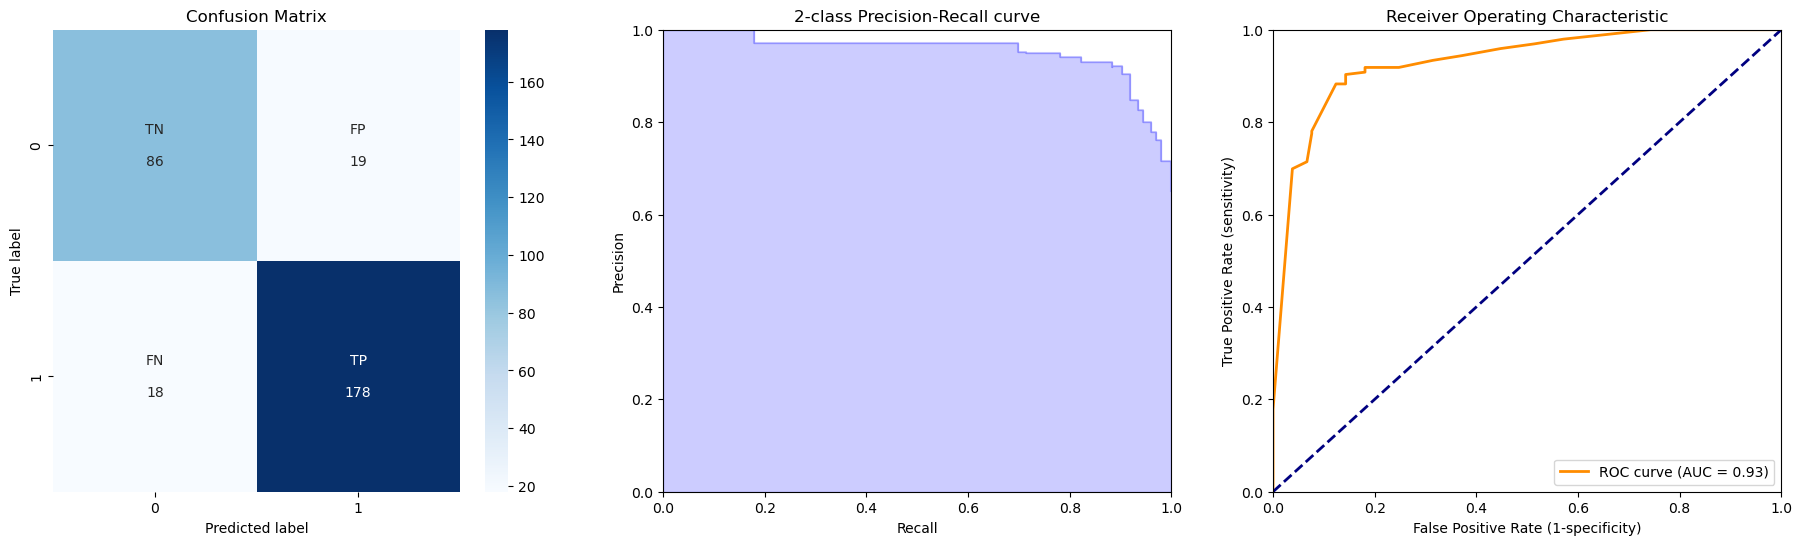


Random Forest

Summary Report
Accuracy:  0.87 [TP / N] Proportion of predicted labels that match true labels
Precision: 0.89 [TP / (TP + FP)] Ability of the classifier not to label as positive a sample that is negative
Recall:    0.91 [TP / (TP + FN)] Ability of the classifier to find all positive samples
F1-score:  0.90 [F1 = 2 * (precision * recall) / (precision + recall)] Harmonic mean of the precision and recall
ROC AUC:   0.85
-----------------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples
----------------------------------------------------------------------------------------------------------------- 



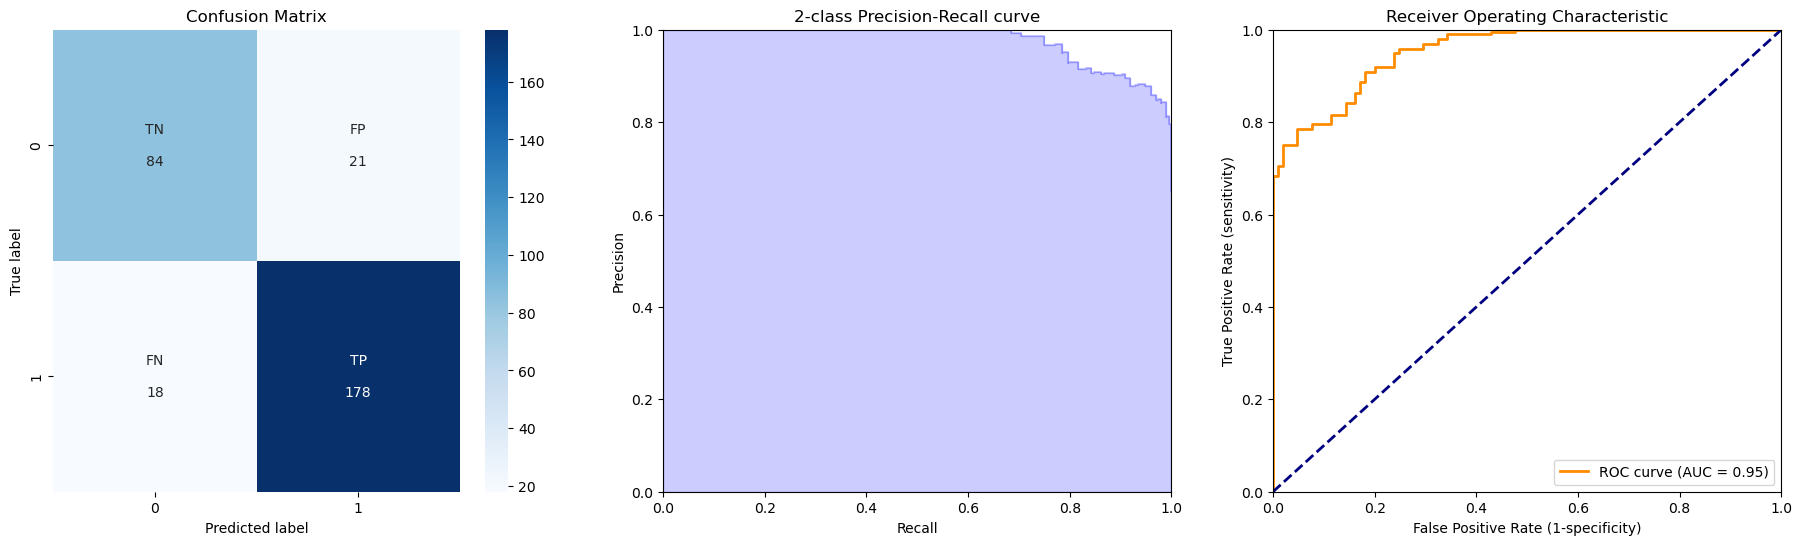


AdaBoost

Summary Report
Accuracy:  0.84 [TP / N] Proportion of predicted labels that match true labels
Precision: 0.85 [TP / (TP + FP)] Ability of the classifier not to label as positive a sample that is negative
Recall:    0.92 [TP / (TP + FN)] Ability of the classifier to find all positive samples
F1-score:  0.88 [F1 = 2 * (precision * recall) / (precision + recall)] Harmonic mean of the precision and recall
ROC AUC:   0.81
-----------------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples
----------------------------------------------------------------------------------------------------------------- 



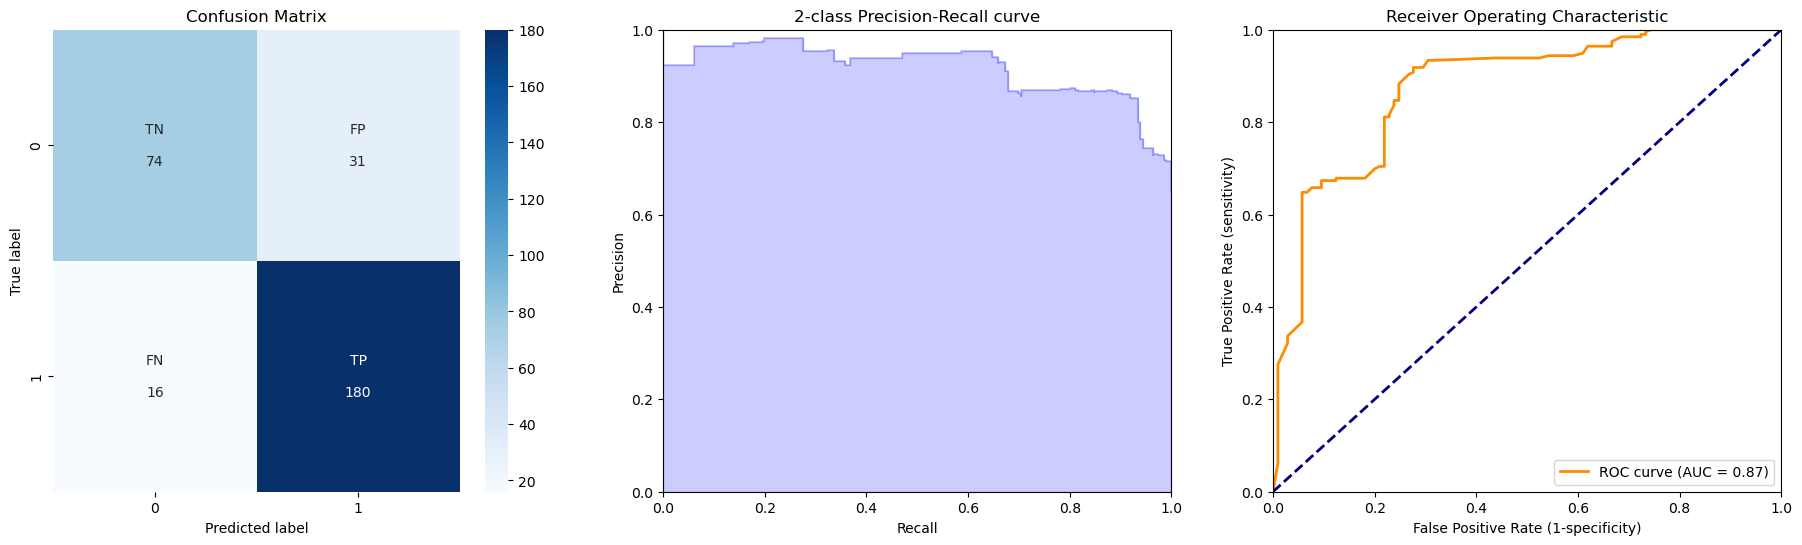


LightGBM

Summary Report
Accuracy:  0.99 [TP / N] Proportion of predicted labels that match true labels
Precision: 1.00 [TP / (TP + FP)] Ability of the classifier not to label as positive a sample that is negative
Recall:    0.99 [TP / (TP + FN)] Ability of the classifier to find all positive samples
F1-score:  0.99 [F1 = 2 * (precision * recall) / (precision + recall)] Harmonic mean of the precision and recall
ROC AUC:   0.99
-----------------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples
----------------------------------------------------------------------------------------------------------------- 



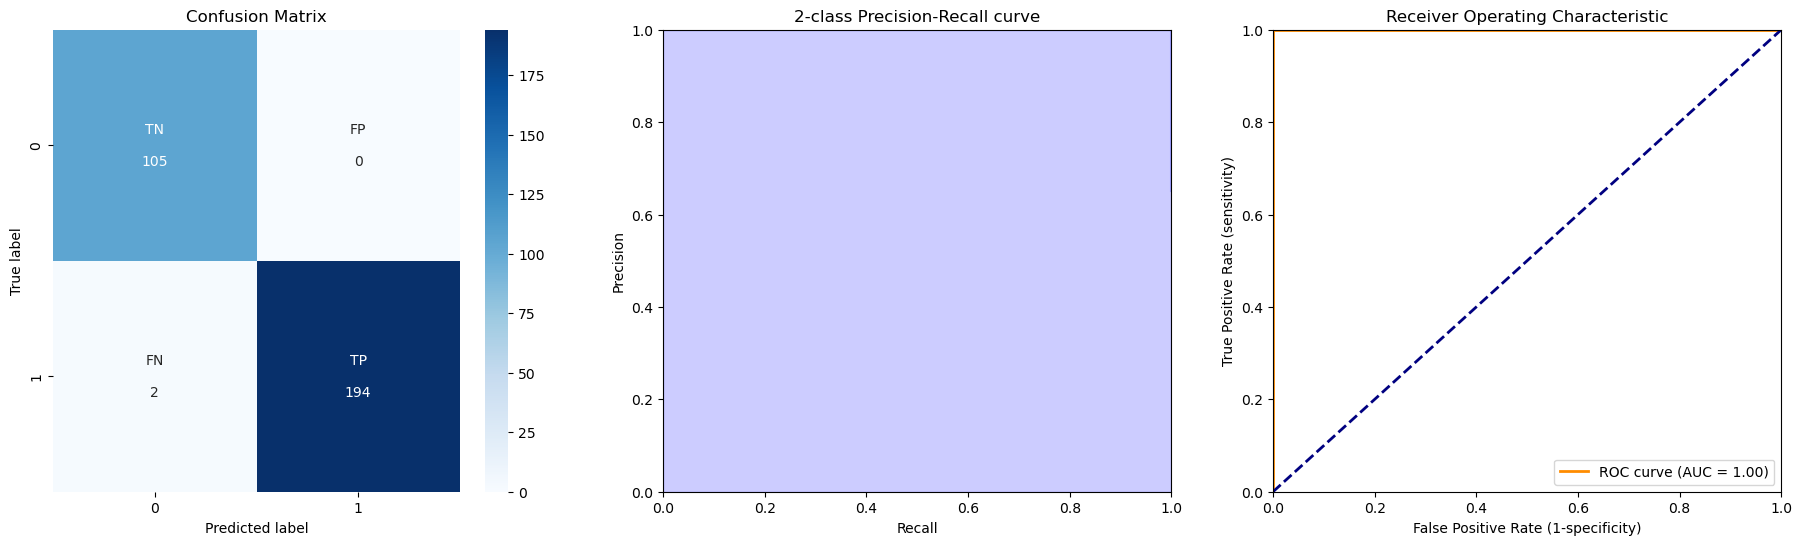


XGBoost

Summary Report
Accuracy:  1.00 [TP / N] Proportion of predicted labels that match true labels
Precision: 1.00 [TP / (TP + FP)] Ability of the classifier not to label as positive a sample that is negative
Recall:    1.00 [TP / (TP + FN)] Ability of the classifier to find all positive samples
F1-score:  1.00 [F1 = 2 * (precision * recall) / (precision + recall)] Harmonic mean of the precision and recall
ROC AUC:   1.00
-----------------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples
----------------------------------------------------------------------------------------------------------------- 



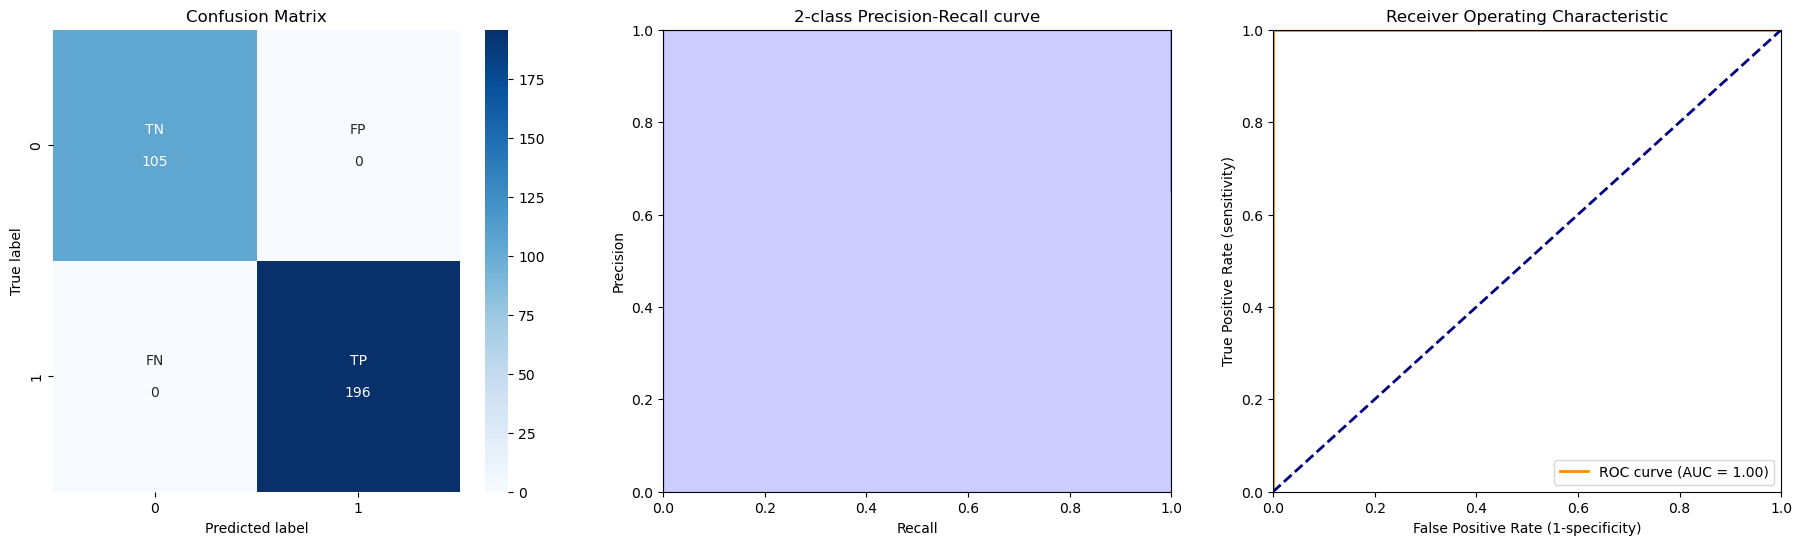


CatBoost

Summary Report
Accuracy:  1.00 [TP / N] Proportion of predicted labels that match true labels
Precision: 1.00 [TP / (TP + FP)] Ability of the classifier not to label as positive a sample that is negative
Recall:    1.00 [TP / (TP + FN)] Ability of the classifier to find all positive samples
F1-score:  1.00 [F1 = 2 * (precision * recall) / (precision + recall)] Harmonic mean of the precision and recall
ROC AUC:   1.00
-----------------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples
----------------------------------------------------------------------------------------------------------------- 



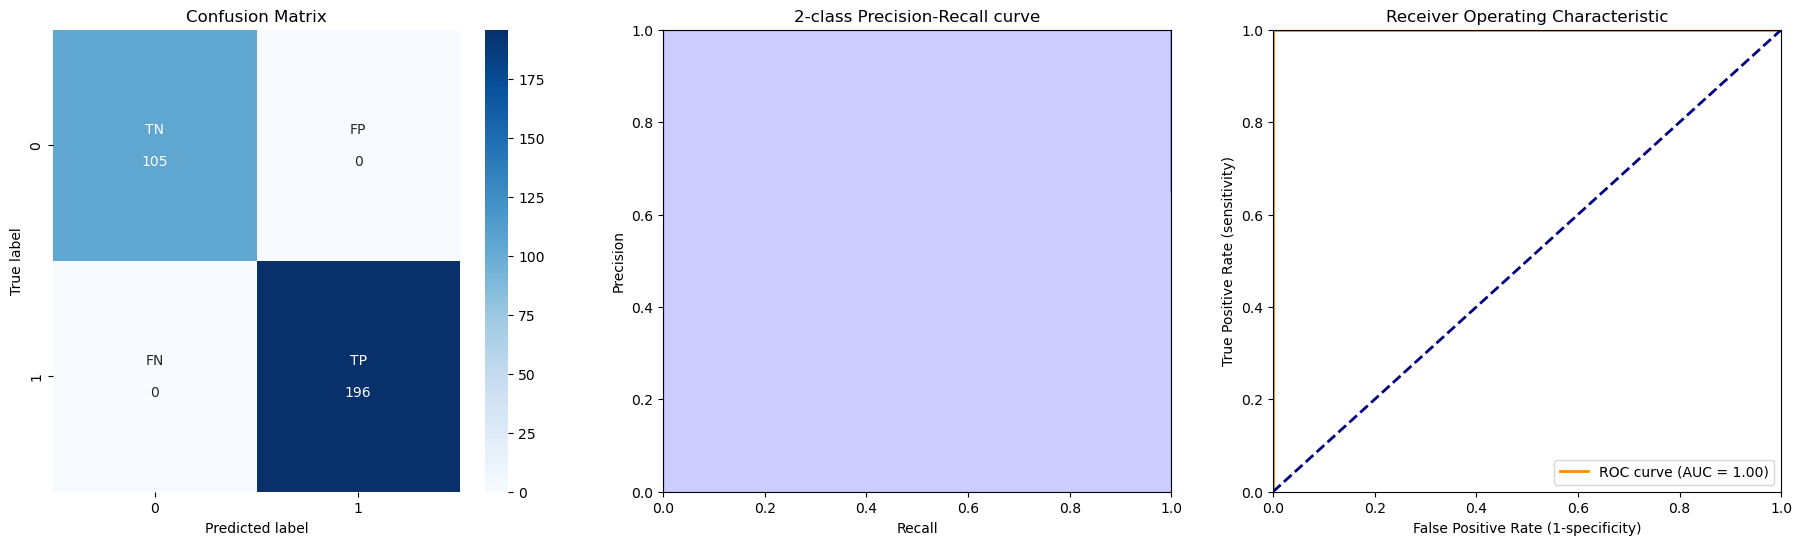

Model    Set  Accuracy  Precision  Recall  F1-score  ROC_AUC
2        AdaBoost  Train     0.853      0.857   0.929     0.892    0.820
8        AdaBoost   Test     0.844      0.853   0.918     0.885    0.812
5        CatBoost  Train     1.000      1.000   1.000     1.000    1.000
11       CatBoost   Test     1.000      1.000   1.000     1.000    1.000
0   Decision Tree  Train     0.895      0.903   0.940     0.921    0.876
6   Decision Tree   Test     0.877      0.904   0.908     0.906    0.864
3        LightGBM  Train     1.000      1.000   1.000     1.000    1.000
9        LightGBM   Test     0.993      1.000   0.990     0.995    0.995
1   Random Forest  Train     0.911      0.923   0.943     0.932    0.897
7   Random Forest   Test     0.870      0.894   0.908     0.901    0.854
4         XGBoost  Train     1.000      1.000   1.000     1.000    1.000
10        XGBoost   Test     1.000      1.000   1.000     1.000    1.000

In [201]:
## Print summary report including all plots, combine performance indicators of all models and append to dataframe

results = results_train.copy()

# Model names
# models = ['Decision Tree_test', 'Random Forest_test', 'Bagging_test', 'AdaBoost_test', 'XGBoost_test', 'CatBoost_test']
models = ['Decision Tree', 'Random Forest', 'AdaBoost', 'LightGBM', 'XGBoost', 'CatBoost']

# Iterate through models
for i, m in enumerate([dtc_gs.best_estimator_, rfc_gs.best_estimator_, ada_gs.best_estimator_, lgb_rs.best_estimator_, xgb_rs.best_estimator_, cbc_rs.best_estimator_]):
    print(f'\n\033[1m{Fore.BLUE}{models[i]}{Style.RESET_ALL}\033[0m\n')
    
    # Summary report
    accuracy_, precision_, recall_, f1_, roc_auc_ = summary_report_tree(m, X_test, y_test)
    
    # Round values
    list = [accuracy_, precision_, recall_, f1_, roc_auc_]
    accuracy_, precision_, recall_, f1_, roc_auc_ = [round(x, 3) for x in list]
    
    # Add results to df
    results.loc[i+len(results_train)] = {'Model': models[i], 'Set': 'Test', 'Accuracy': accuracy_, 'Precision': precision_,
                                         'Recall': recall_, 'F1-score': f1_, 'ROC_AUC': roc_auc_}    

# Copy results
results_tree_models = results.copy()

# Print dataframe with performance indicators for all models
print('\n')
results.sort_values(by=['Model', 'Set'], ascending = [True, False])

**Documentation**
* CatBoost and XGBoost are the best performers, closely followed by LightGBM 
* Decision Tree and Random Forest are midfield
* AdaBoost is the worst performer

## 6.4. Neural network-based models

In [ ]:
X_train.head()

age  feeling_sad_or_tearful_No  feeling_sad_or_tearful_Sometimes  \
133     4                          0                                 0   
35      2                          0                                 1   
984     3                          0                                 1   
110     3                          0                                 0   
1465    2                          0                                 1   

      feeling_sad_or_tearful_Yes  irritable_towards_baby_and_partner_No  \
133                            1                                      0   
35                             0                                      0   
984                            0                                      1   
110                            1                                      1   
1465                           0                                      1   

      irritable_towards_baby_and_partner_Sometimes  \
133                                              0   
35                                               1   
984                                              0   
110                                              0   
1465                                             0   

      irritable_towards_baby_and_partner_Yes  trouble_sleeping_at_night_No  \
133                                        1                             1   
35                                         0                             0   
984                                        0                             1   
110                                        0                             0   
1465                                       0                             1   

      trouble_sleeping_at_night_Two or more days a week  \
133                                                   0   
35                                                    0   
984                                                   0   
110                                                   0   
1465                                                  0   

      trouble_sleeping_at_night_Yes  ...  overeating_or_loss_of_appetite_Yes  \
133                               0  ...                                   0   
35                                1  ...                                   0   
984                               0  ...                                   0   
110                               1  ...                                   0   
1465                              0  ...                                   0   

      feeling_of_guilt_Maybe  feeling_of_guilt_No  feeling_of_guilt_Yes  \
133                        0                    0                     1   
35                         1                    0                     0   
984                        1                    0                     0   
110                        0                    1                     0   
1465                       1                    0                     0   

      problems_of_bonding_with_baby_No  \
133                                  0   
35                                   0   
984                                  0   
110                                  0   
1465                                 0   

      problems_of_bonding_with_baby_Sometimes  \
133                                         1   
35                                          0   
984                                         0   
110                                         1   
1465                                        0   

      problems_of_bonding_with_baby_Yes  suicide_attempt_No  \
133                                   0                   0   
35                                    1                   0   
984                                   1                   1   
110                                   0                   1   
1465                                  1                   1   

      suicide_attempt_Not interested to say  suicide_attempt_Yes  
133                                

In [ ]:
y_train

array([0, 1, 1, ..., 0, 0, 1])

### 6.4.1. Fully connected model

**Model architecture**

In [234]:
# Define model
clear_session()

n_cols = X_train.shape[1]

model = Sequential()
model.add(Dense(40, input_shape = (n_cols,), activation = 'relu'))
model.add(Dense(40, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))

**Compile model**

In [235]:
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                1040      
                                                                 
 dense_1 (Dense)             (None, 40)                1640      
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 41        
                                                                 
Total params: 2,721
Trainable params: 2,721
Non-trainable params: 0
_________________________________________________________________


**Fit model**

In [236]:
%%time

# Fit model
epochs = 50
batch_size = 10

history = model.fit(X_train, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size, verbose=0)

CPU times: total: 18.2 s
Wall time: 10.4 s


In [218]:
# List data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


**Learning curves**

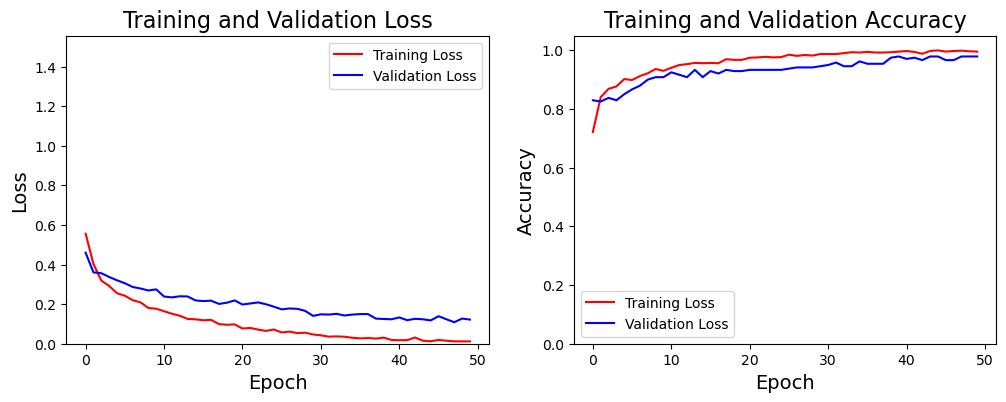

In [219]:
learning_curve_nn(history)

**Model evaluation**

In [237]:
# Evaluate model with test data
scores = model.evaluate(X_test, y_test, verbose = 0)
print(f'Test loss: {scores[0]:.4f}') 
print(f'Test accuracy: {scores[1]:.4f}')

Test loss: 0.0852
Test accuracy: 0.9734


In [238]:
# Alternatively
for i, m in enumerate(model.metrics_names):
    print(f"{m}: {scores[i]:.4f}")

loss: 0.0852
accuracy: 0.9734


**Model prediction**

In [239]:
test_size = 5

# Use model.predict() to extract class probabilities
pred_prob = model.predict(X_test[:test_size]) 
pred_prob

1/1 [==============================] - 0s 61ms/step


array([[1.2823368e-02],
       [6.5951626e-04],
       [1.9036273e-02],
       [9.9993664e-01],
       [9.9999064e-01]], dtype=float32)

In [240]:
# Set a probability threshold of 50% for classification, i.e. >0.5 is True
# Note! The '*1' converts the Boolean array into an array containing 0 or 1
pred = (pred_prob > 0.5)*1
pred.flatten()

array([0, 0, 0, 1, 1])

In [241]:
# Inverse label encoding
pred_ = le.inverse_transform(pred.flatten())
pred_

array(['No', 'No', 'No', 'Yes', 'Yes'], dtype=object)

In [242]:
# Prediction in a single line of code
pred_ = le.inverse_transform(((model.predict(X_test[:test_size])>0.5)*1).flatten())
pred_

1/1 [==============================] - 0s 22ms/step


array(['No', 'No', 'No', 'Yes', 'Yes'], dtype=object)

In [243]:
y_test[:test_size]

array([0, 0, 0, 1, 1])

In [244]:
# Retrieve true values from y_test
true_y = le.inverse_transform(y_test[:test_size])
true_y

array(['No', 'No', 'No', 'Yes', 'Yes'], dtype=object)

In [245]:
# Compare prediction and true values
for i,j in zip(pred_, true_y):
    print("Predicted: {}, True: {}".format(i, j))

Predicted: No, True: No
Predicted: No, True: No
Predicted: No, True: No
Predicted: Yes, True: Yes
Predicted: Yes, True: Yes


In [246]:
# Compile results in df
pd.DataFrame(zip(pred_, true_y), columns=['feeling_anxious_Predicted', 'feeling_anxious_Actual'])

feeling_anxious_Predicted feeling_anxious_Actual
0                        No                     No
1                        No                     No
2                        No                     No
3                       Yes                    Yes
4                       Yes                    Yes

In [247]:
# Model prediction on entire test set
pred_ = le.inverse_transform(((model.predict(X_test)>0.5)*1).flatten())
true_y = le.inverse_transform(y_test)

10/10 [==============================] - 0s 2ms/step


In [249]:
print(classification_report(true_y, pred_))

              precision    recall  f1-score   support

          No       0.96      0.95      0.96       105
         Yes       0.97      0.98      0.98       196

    accuracy                           0.97       301
   macro avg       0.97      0.97      0.97       301
weighted avg       0.97      0.97      0.97       301



### 6.4.2. Model evaluation

#### Evaluation of neural network-based models on training data


Neural Network

38/38 [==============================] - 0s 1ms/step

Summary Report
Accuracy:  0.99 [TP / N] Proportion of predicted labels that match true labels
Precision: 1.00 [TP / (TP + FP)] Ability of the classifier not to label as positive a sample that is negative
Recall:    0.99 [TP / (TP + FN)] Ability of the classifier to find all positive samples
F1-score:  1.00 [F1 = 2 * (precision * recall) / (precision + recall)] Harmonic mean of the precision and recall
ROC AUC:   0.99
-----------------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples
----------------------------------------------------------------------------------------------------------------- 



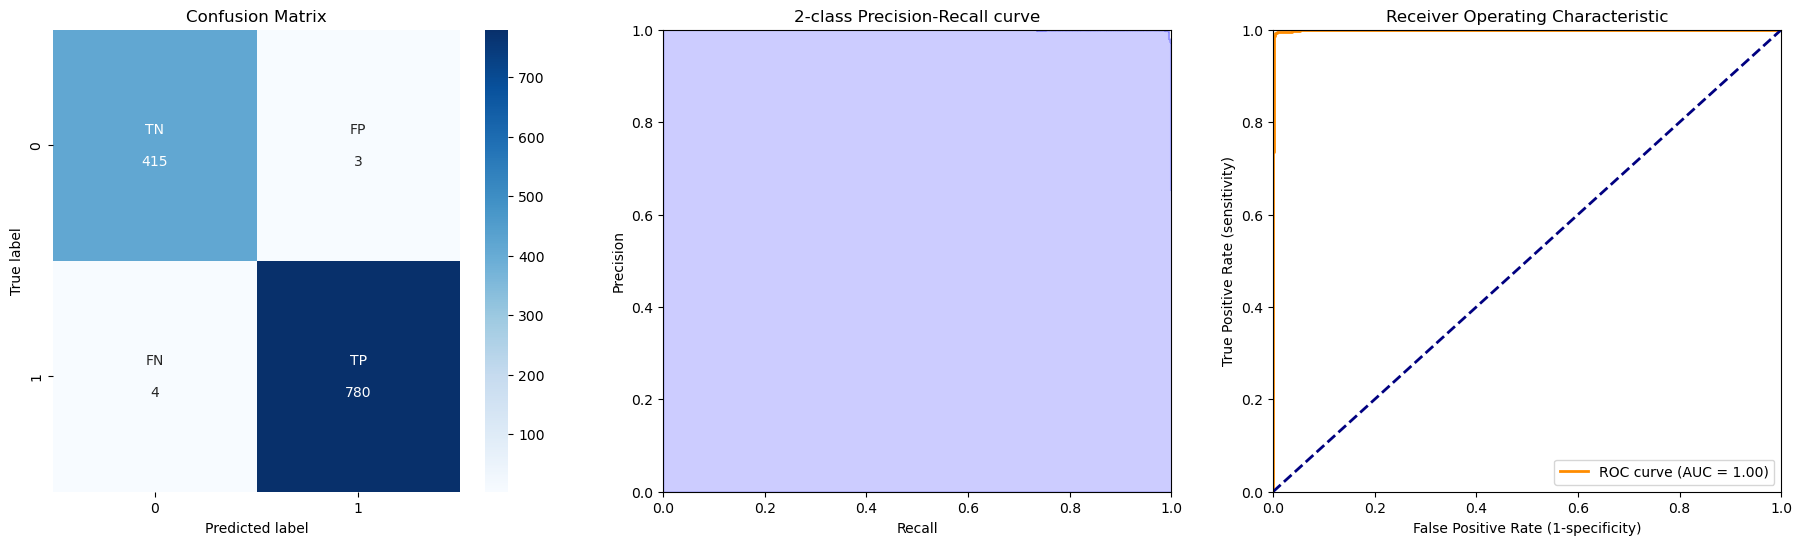

Model    Set  Accuracy  Precision  Recall  F1-score  ROC_AUC
0  Neural Network  Train     0.994      0.996   0.995     0.996    0.994

In [250]:
## Print summary report including all plots and combine performance indicators of all models in a dataframe

# Create empty df with column headers
column_names = ['Model', 'Set', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC_AUC']
results_train = pd.DataFrame(columns=column_names)

# Model names
models = ['Neural Network']

# Iterate through models
for i, m in enumerate([model]):
    print(f'\n\033[1m{Fore.BLUE}{models[i]}{Style.RESET_ALL}\033[0m\n')
    
    # Summary report
    accuracy_, precision_, recall_, f1_, roc_auc_ = summary_report_nn(m, X_train, y_train)
    
    # Round values
    list = [accuracy_, precision_, recall_, f1_, roc_auc_]
    accuracy_, precision_, recall_, f1_, roc_auc_ = [round(x, 3) for x in list]
    
    # Add results to df
    results_train.loc[i] = {'Model': models[i], 'Set': 'Train', 'Accuracy': accuracy_, 'Precision': precision_,
                            'Recall': recall_, 'F1-score': f1_, 'ROC_AUC': roc_auc_}    

# Print dataframe with performance indicators for all models
print('\n')
results_train.sort_values(by='Model')

#### Evaluation of neural network-based models on testing data


Neural Network

10/10 [==============================] - 0s 2ms/step

Summary Report
Accuracy:  0.97 [TP / N] Proportion of predicted labels that match true labels
Precision: 0.98 [TP / (TP + FP)] Ability of the classifier not to label as positive a sample that is negative
Recall:    0.97 [TP / (TP + FN)] Ability of the classifier to find all positive samples
F1-score:  0.98 [F1 = 2 * (precision * recall) / (precision + recall)] Harmonic mean of the precision and recall
ROC AUC:   0.97
-----------------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples
----------------------------------------------------------------------------------------------------------------- 



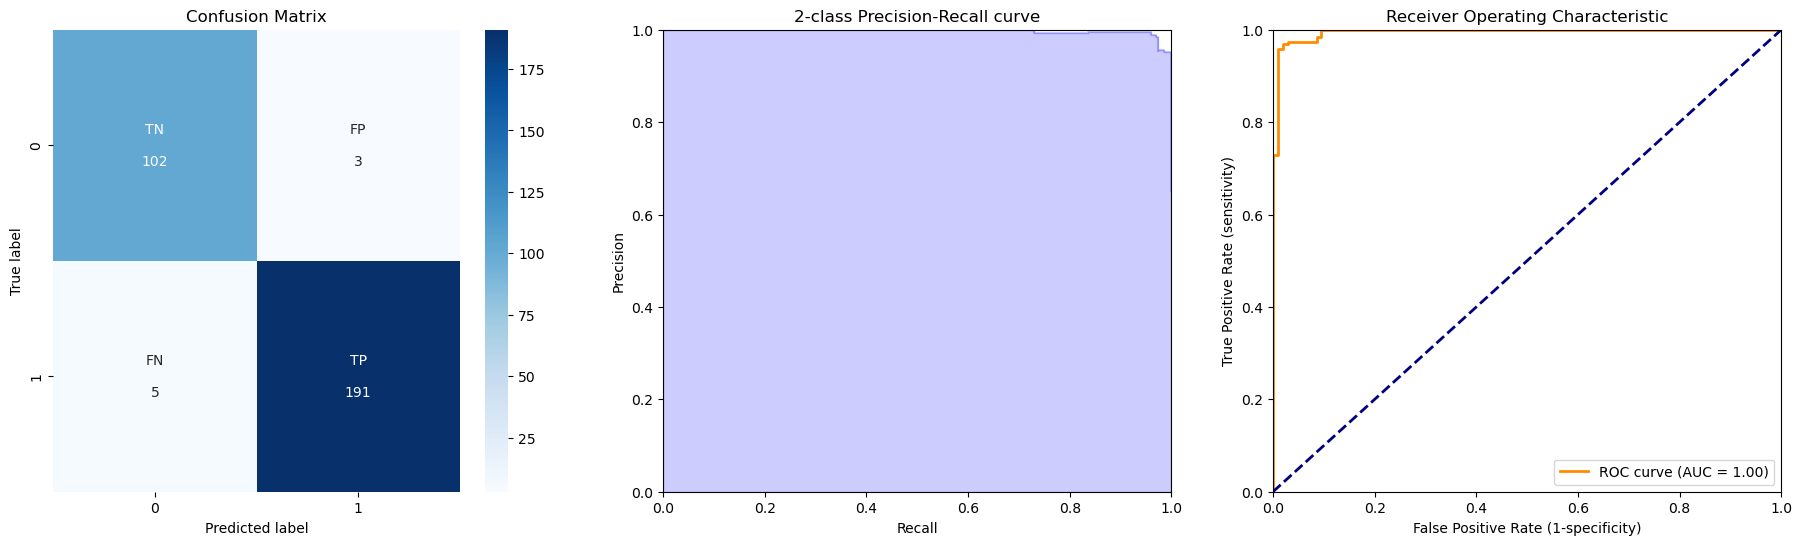

Model    Set  Accuracy  Precision  Recall  F1-score  ROC_AUC
0  Neural Network  Train     0.994      0.996   0.995     0.996    0.994
1  Neural Network   Test     0.973      0.985   0.974     0.979    0.973

In [251]:
## Print summary report including all plots, combine performance indicators of all models and append to dataframe

results = results_train.copy()

# Model names
models = ['Neural Network']

# Iterate through models
for i, m in enumerate([model]):
    print(f'\n\033[1m{Fore.BLUE}{models[i]}{Style.RESET_ALL}\033[0m\n')
    
    # Summary report
    accuracy_, precision_, recall_, f1_, roc_auc_ = summary_report_nn(m, X_test, y_test)
    
    # Round values
    list = [accuracy_, precision_, recall_, f1_, roc_auc_]
    accuracy_, precision_, recall_, f1_, roc_auc_ = [round(x, 3) for x in list]
    
    # Add results to df
    results.loc[i+len(results_train)] = {'Model': models[i], 'Set': 'Test', 'Accuracy': accuracy_, 'Precision': precision_,
                                         'Recall': recall_, 'F1-score': f1_, 'ROC_AUC': roc_auc_}    

# Copy results
results_nn_models = results.copy()

# Print dataframe with performance indicators for all models
print('\n')
results.sort_values(by=['Model', 'Set'], ascending = [True, False])

## 6.5. Combined model results table

In [252]:
pd.concat([results_tree_models, results_nn_models]).sort_values(by=['Model', 'Set'], ascending = [True, False])

Model    Set  Accuracy  Precision  Recall  F1-score  ROC_AUC
2         AdaBoost  Train     0.853      0.857   0.929     0.892    0.820
8         AdaBoost   Test     0.844      0.853   0.918     0.885    0.812
5         CatBoost  Train     1.000      1.000   1.000     1.000    1.000
11        CatBoost   Test     1.000      1.000   1.000     1.000    1.000
0    Decision Tree  Train     0.895      0.903   0.940     0.921    0.876
6    Decision Tree   Test     0.877      0.904   0.908     0.906    0.864
3         LightGBM  Train     1.000      1.000   1.000     1.000    1.000
9         LightGBM   Test     0.993      1.000   0.990     0.995    0.995
0   Neural Network  Train     0.994      0.996   0.995     0.996    0.994
1   Neural Network   Test     0.973      0.985   0.974     0.979    0.973
1    Random Forest  Train     0.911      0.923   0.943     0.932    0.897
7    Random Forest   Test     0.870      0.894   0.908     0.901    0.854
4          XGBoost  Train     1.000      1.000   1.000     1.000    1.000
10         XGBoost   Test     1.000      1.000   1.000     1.000    1.000

**Documentation**
* CatBoost and XGBoost are the best performers, closely followed by LightGBM 
* The neural network-based model performs slightly worse than LightGBM
* Decision Tree and Random Forest are midfield
* AdaBoost is the worst performer

## References
1. [Miller, L.J. (2002) Postpartum Depression. JAMA, 287(6):762–765](https://jamanetwork.com/journals/jama/article-abstract/194624)
2. [Stewart, D.E., Vigod, S. (2016) Postpartum depression. N Engl J Med, 375:2177-2186](https://www.nejm.org/doi/full/10.1056/nejmcp1607649)
3. [Wisner, K.L., et al. (2013) Onset timing, thoughts of self-harm, and diagnoses in postpartum women with screen-positive depression findings. JAMA Psychiatry, 70(5):490-498](https://jamanetwork.com/journals/jamapsychiatry/article-abstract/1666651)